Google Cluster Cloud Task Scheduling with Hybrid FAO
Detected headers in CSV file
Error loading CSV file: arg must be a list, tuple, 1-d array, or Series
Creating sample data based on your data structure...
Creating sample data...
Created 100 tasks from data
Created 20 VMs based on machine data
Initialized GoogleClusterScheduler with 100 tasks and 20 VMs

=== Task Statistics ===
Total tasks: 100
Task lengths - Min: 2.260, Max: 99.664, Mean: 51.850
CPU requests - Min: 0.002260, Max: 0.099664
Memory requests - Min: 0.001257, Max: 0.049727
Scheduling class distribution: {0: 19, 1: 29, 2: 26, 3: 26}
Starting Google Cluster Hybrid FAO with Energy-Aware Load Balancing

=== Step 1: Initializing Firefly Population ===
Initialized 20 fireflies
Best initial fitness: 0.182

=== Step 2: Firefly Algorithm Phase ===
FA Generation 0: Best fitness = 0.164
FA Generation 5: Best fitness = 0.164
FA Generation 10: Best fitness = 0.164
FA Generation 15: Best fitness = 0.164
FA Generation 20: Best fitness =

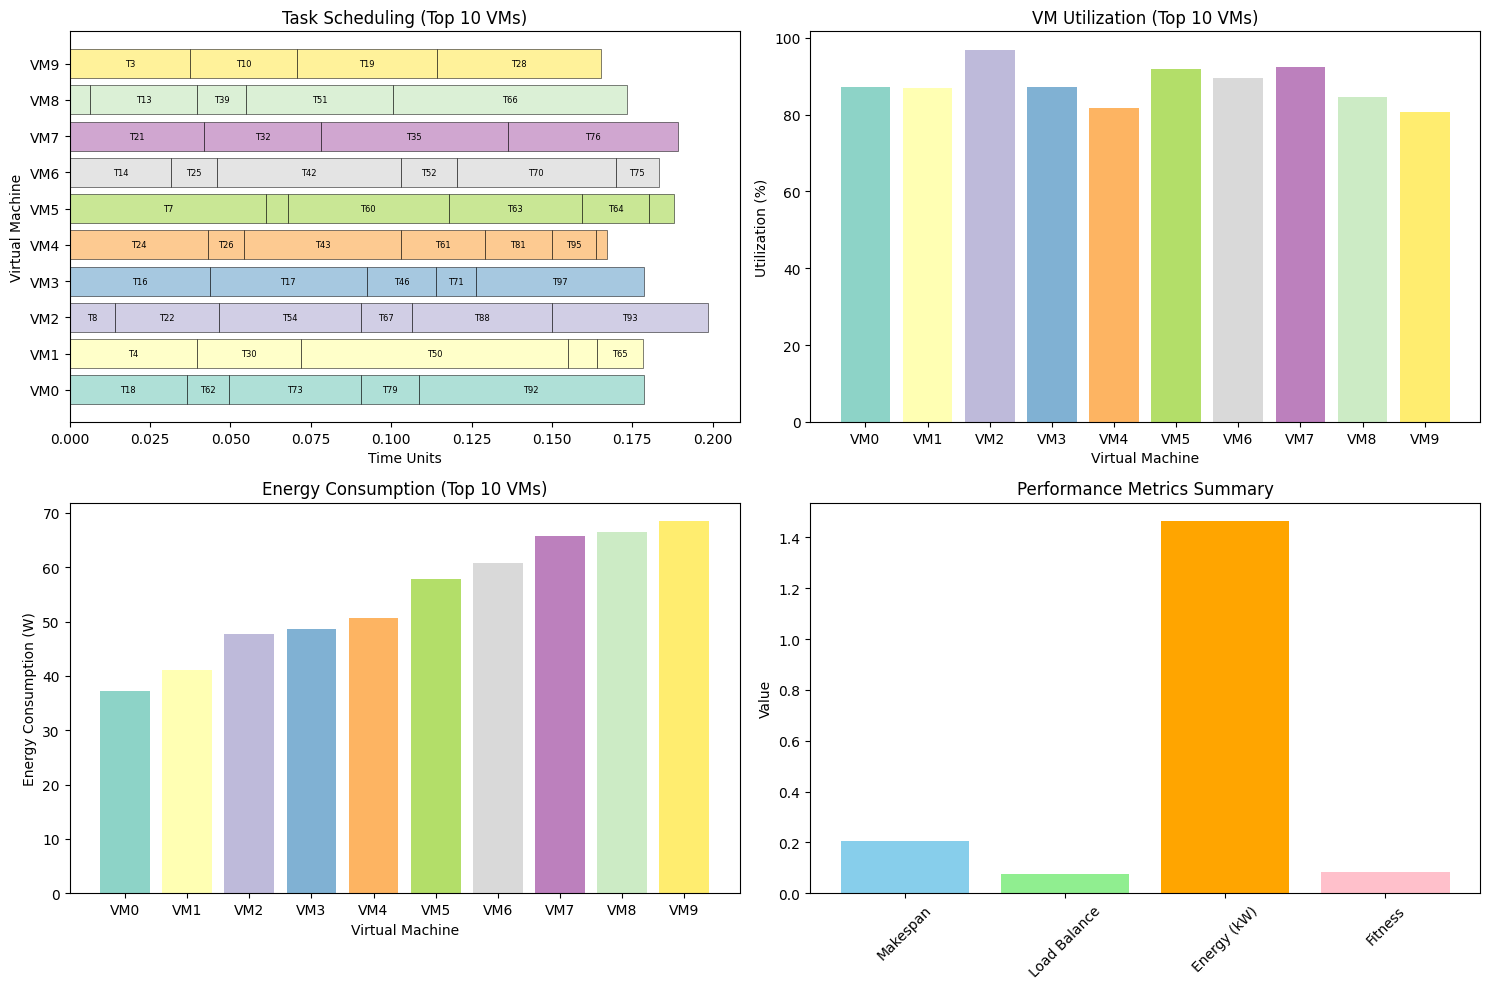


=== Cluster Data Insights ===
Unique collections in data: 100
Unique machines in data: 20
Tasks processed: 100
VMs created: 20
Total CPU demand: 5.185019
Total Memory demand: 2.537984


In [ ]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import List, Tuple, Dict
import copy
import os

@dataclass
class Task:
    """Represents a task with its properties extracted from Google cluster trace"""
    id: int
    length: float  # CPU usage or workload (normalized)
    arrival_time: int = 0
    priority: int = 0
    cpu_request: float = 0.0
    memory_request: float = 0.0
    collection_id: int = 0
    scheduling_class: int = 0

@dataclass
class VirtualMachine:
    """Represents a VM with its properties"""
    id: int
    mips: float  # Processing capacity (normalized)
    power_idle: float  # Power consumption when idle (watts)
    power_busy: float  # Power consumption when busy (watts)
    is_active: bool = True
    cpu_capacity: float = 1.0
    memory_capacity: float = 1.0

class GoogleClusterScheduler:
    """Cloud scheduler for Google cluster trace data with Hybrid FAO and Energy-Aware Load Balancing"""

    def __init__(self, csv_file_path: str, alpha=0.4, beta=0.3, gamma=0.3, load_threshold=0.8, max_tasks=1000):
        # Load and preprocess the data
        self.df = self.load_cluster_data(csv_file_path, max_tasks)
        self.tasks = self.create_tasks_from_data()
        self.vms = self.create_vms_from_data()

        self.n_tasks = len(self.tasks)
        self.n_vms = len(self.vms)

        # Fitness function weights
        self.alpha = alpha  # Makespan weight
        self.beta = beta    # Load balance weight
        self.gamma = gamma  # Energy weight

        # Load balancing parameters
        self.load_threshold = load_threshold
        self.idle_threshold = 10  # Time units before considering VM for shutdown

        # Algorithm parameters
        self.max_generations = 50  # Reduced for large datasets
        self.population_size = 20  # Reduced for performance
        self.firefly_pop = []

        print(f"Initialized GoogleClusterScheduler with {self.n_tasks} tasks and {self.n_vms} VMs")

    def load_cluster_data(self, csv_file_path: str, max_tasks: int) -> pd.DataFrame:
        """Load and preprocess Google cluster trace data"""
        try:
            # First, try to detect if the file has headers
            sample_df = pd.read_csv(csv_file_path, nrows=1)
            has_headers = any('time' in str(col).lower() or 'collection' in str(col).lower()
                            for col in sample_df.columns)

            if has_headers:
                # Load with existing headers
                print("Detected headers in CSV file")
                df = pd.read_csv(csv_file_path, nrows=max_tasks)

                # Map common column variations to standard names
                column_mapping = {}
                for col in df.columns:
                    col_lower = str(col).lower().strip()
                    if 'time' in col_lower and 'start' not in col_lower and 'end' not in col_lower:
                        column_mapping[col] = 'time'
                    elif 'collection_id' in col_lower:
                        column_mapping[col] = 'collection_id'
                    elif 'machine_id' in col_lower:
                        column_mapping[col] = 'machine_id'
                    elif 'scheduling_class' in col_lower:
                        column_mapping[col] = 'scheduling_class'
                    elif 'priority' in col_lower:
                        column_mapping[col] = 'priority'
                    elif 'resource_request' in col_lower:
                        column_mapping[col] = 'resource_request'
                    elif 'start_time' in col_lower:
                        column_mapping[col] = 'start_time'
                    elif 'end_time' in col_lower:
                        column_mapping[col] = 'end_time'

                df = df.rename(columns=column_mapping)

            else:
                # Load without headers and assign column names
                print("No headers detected, assigning column names")
                columns = [
                    'time', 'instance_events_type', 'collection_id', 'scheduling_class',
                    'collection_type', 'priority', 'alloc_collection_id', 'instance_index',
                    'machine_id', 'resource_request', 'constraint', 'collections_events_type',
                    'user', 'collection_name', 'collection_logical_name', 'start_after_collection_ids',
                    'vertical_scaling', 'scheduler', 'start_time', 'end_time', 'average_usage',
                    'maximum_usage', 'random_sample_usage', 'assigned_memory', 'page_cache_memory',
                    'cycles_per_instruction', 'memory_accesses_per_instruction', 'sample_rate',
                    'cpu_usage_distribution', 'tail_cpu_usage_distribution', 'cluster', 'event', 'failed'
                ]

                df = pd.read_csv(csv_file_path, names=columns, nrows=max_tasks)

            # Clean and preprocess data
            # Convert numeric columns safely
            numeric_columns = ['collection_id', 'machine_id', 'priority', 'scheduling_class', 'time']
            for col in numeric_columns:
                if col in df.columns:
                    df[col] = pd.to_numeric(df[col], errors='coerce')

            # Remove rows where essential columns are NaN
            essential_cols = [col for col in ['machine_id', 'collection_id'] if col in df.columns]
            if essential_cols:
                df = df.dropna(subset=essential_cols)
            df = df.reset_index(drop=True)


            # Parse resource_request if it exists
            if 'resource_request' in df.columns:
                df['cpu_request'] = 0.001  # Default value
                df['memory_request'] = 0.001  # Default value

                for idx, row in df.iterrows():
                    try:
                        resource_val = row['resource_request']
                        if pd.notna(resource_val) and isinstance(resource_val, str):
                            # Parse dictionary-like string
                            if 'cpus' in resource_val:
                                # Extract CPU value using string parsing
                                cpu_start = resource_val.find("'cpus': ") + 8
                                if cpu_start > 7:  # Found 'cpus'
                                    cpu_end = resource_val.find(",", cpu_start)
                                    if cpu_end == -1:
                                        cpu_end = resource_val.find("}", cpu_start)
                                    if cpu_end > cpu_start:
                                        cpu_str = resource_val[cpu_start:cpu_end].strip()
                                        df.loc[idx, 'cpu_request'] = float(cpu_str)

                            if 'memory' in resource_val:
                                # Extract memory value
                                memory_start = resource_val.find("'memory': ") + 10
                                if memory_start > 9:  # Found 'memory'
                                    memory_end = resource_val.find("}", memory_start)
                                    if memory_end > memory_start:
                                        memory_str = resource_val[memory_start:memory_end].strip()
                                        if memory_str != 'None' and memory_str:
                                            df.loc[idx, 'memory_request'] = float(memory_str)
                        elif pd.notna(resource_val) and isinstance(resource_val, (int, float)):
                            # If it's already a number, use it as CPU request
                            df.loc[idx, 'cpu_request'] = float(resource_val)
                    except Exception as e:
                        # Keep default values on parsing error
                        continue
            else:
                # If no resource_request column, create defaults
                df['cpu_request'] = np.random.uniform(0.001, 0.1, len(df))
                df['memory_request'] = np.random.uniform(0.001, 0.05, len(df))

            # Ensure essential columns exist with defaults if missing
            if 'priority' not in df.columns:
                df['priority'] = np.random.randint(0, 12, len(df))
            if 'scheduling_class' not in df.columns:
                df['scheduling_class'] = np.random.randint(0, 4, len(df))
            if 'start_time' not in df.columns:
                df['start_time'] = np.random.randint(0, 1000, len(df))
            if 'end_time' not in df.columns:
                df['end_time'] = df['start_time'] + np.random.randint(100, 2000, len(df))
            if 'machine_id' not in df.columns:
                df['machine_id'] = np.random.randint(0, 50, len(df))
            if 'collection_id' not in df.columns:
                df['collection_id'] = range(len(df))

            print(f"Loaded {len(df)} records from cluster trace data")
            print(f"Columns found: {list(df.columns)}")
            return df
        except Exception as e:
            print(f"Error loading CSV file: {e}")
            print("Creating sample data based on your data structure...")
            # Return sample data if file loading fails
            return self.create_sample_dataframe(max_tasks)

    def create_sample_dataframe(self, max_tasks: int) -> pd.DataFrame:
        """Create sample dataframe if CSV loading fails"""
        print("Creating sample data...")
        data = []
        for i in range(min(max_tasks, 100)):
            data.append({
                'collection_id': i,
                'machine_id': random.randint(0, 19),
                'cpu_request': random.uniform(0.001, 0.1),
                'memory_request': random.uniform(0.001, 0.05),
                'priority': random.randint(0, 11),
                'scheduling_class': random.randint(0, 3),
                'start_time': random.randint(0, 1000),
                'end_time': random.randint(1001, 2000)
            })
        return pd.DataFrame(data)

    def create_tasks_from_data(self) -> List[Task]:
        """Create Task objects from loaded data"""
        tasks = []

        for idx, row in self.df.iterrows():
            # Use CPU request as task length (workload)
            length = max(row.get('cpu_request', 0.001), 0.001)  # Minimum workload

            # Scale up for better visualization
            length *= 1000

            task = Task(
                id=idx,
                length=length,
                arrival_time=int(row.get('start_time', 0)),
                priority=int(row.get('priority', 0)),
                cpu_request=row.get('cpu_request', 0.001),
                memory_request=row.get('memory_request', 0.001),
                collection_id=int(row.get('collection_id', 0)),
                scheduling_class=int(row.get('scheduling_class', 0))
            )
            tasks.append(task)

        print(f"Created {len(tasks)} tasks from data")
        return tasks

    def create_vms_from_data(self) -> List[VirtualMachine]:
        """Create VM objects based on unique machines in data"""
        # Get unique machine IDs
        unique_machines = self.df['machine_id'].unique()
        vms = []

        for i, machine_id in enumerate(unique_machines[:20]):  # Limit to 20 VMs for performance
            # Vary VM capabilities based on machine characteristics
            base_mips = 1000 + (hash(str(machine_id)) % 1000)  # Pseudo-random but consistent

            vm = VirtualMachine(
                id=i,
                mips=base_mips,
                power_idle=80 + (i * 10),  # Varying idle power
                power_busy=200 + (i * 20),  # Varying busy power
                cpu_capacity=0.8 + (i % 5) * 0.05,  # Varying CPU capacity
                memory_capacity=0.7 + (i % 6) * 0.05  # Varying memory capacity
            )
            vms.append(vm)

        print(f"Created {len(vms)} VMs based on machine data")
        return vms

    def initialize_population(self):
        """Step 1: Initialize Firefly population with random task-VM mappings"""
        print("\n=== Step 1: Initializing Firefly Population ===")

        self.firefly_pop = []
        for i in range(self.population_size):
            # Each firefly represents a task-to-VM mapping
            mapping = [random.randint(0, self.n_vms - 1) for _ in range(self.n_tasks)]
            fitness = self.calculate_fitness(mapping)

            firefly = {
                'mapping': mapping,
                'fitness': fitness,
                'brightness': 1.0 / (1.0 + fitness)  # Higher brightness for lower fitness
            }
            self.firefly_pop.append(firefly)

        # Sort population by fitness (ascending - lower is better)
        self.firefly_pop.sort(key=lambda x: x['fitness'])
        print(f"Initialized {self.population_size} fireflies")
        print(f"Best initial fitness: {self.firefly_pop[0]['fitness']:.3f}")

    def calculate_fitness(self, mapping: List[int]) -> float:
        """Calculate fitness based on makespan, load balance, and energy consumption"""
        makespan = self.calculate_makespan(mapping)
        load_balance_index = self.calculate_load_balance_index(mapping)
        energy_consumption = self.calculate_energy_consumption(mapping)

        # Normalize values
        max_possible_makespan = sum(task.length for task in self.tasks) / min(vm.mips for vm in self.vms)
        normalized_makespan = makespan / max_possible_makespan if max_possible_makespan > 0 else 0

        fitness = (self.alpha * normalized_makespan +
                  self.beta * load_balance_index +
                  self.gamma * energy_consumption / 10000)  # Energy normalization

        return fitness

    def calculate_makespan(self, mapping: List[int]) -> float:
        """Calculate makespan for given task-VM mapping"""
        vm_completion_times = [0.0] * self.n_vms

        for task_idx, vm_idx in enumerate(mapping):
            if vm_idx < self.n_vms and task_idx < len(self.tasks):
                execution_time = self.tasks[task_idx].length / self.vms[vm_idx].mips
                vm_completion_times[vm_idx] += execution_time

        return max(vm_completion_times) if vm_completion_times else 0.0

    def calculate_load_balance_index(self, mapping: List[int]) -> float:
        """Calculate load balance index (lower is better)"""
        vm_loads = [0.0] * self.n_vms

        for task_idx, vm_idx in enumerate(mapping):
            if vm_idx < self.n_vms and task_idx < len(self.tasks):
                vm_loads[vm_idx] += self.tasks[task_idx].length / self.vms[vm_idx].mips

        if len(vm_loads) == 0:
            return 0.0

        mean_load = np.mean(vm_loads)
        if mean_load == 0:
            return 0.0

        # Standard deviation normalized by mean
        load_balance_index = np.std(vm_loads) / mean_load
        return load_balance_index

    def calculate_energy_consumption(self, mapping: List[int]) -> float:
        """Calculate total energy consumption"""
        vm_busy_times = [0.0] * self.n_vms

        for task_idx, vm_idx in enumerate(mapping):
            if vm_idx < self.n_vms and task_idx < len(self.tasks):
                execution_time = self.tasks[task_idx].length / self.vms[vm_idx].mips
                vm_busy_times[vm_idx] += execution_time

        total_energy = 0.0
        makespan = max(vm_busy_times) if vm_busy_times else 0.0

        for vm_idx, busy_time in enumerate(vm_busy_times):
            idle_time = max(0, makespan - busy_time)
            energy = (busy_time * self.vms[vm_idx].power_busy +
                     idle_time * self.vms[vm_idx].power_idle)
            total_energy += energy

        return total_energy

    def firefly_algorithm_phase(self):
        """Step 2: Firefly Algorithm Phase"""
        print("\n=== Step 2: Firefly Algorithm Phase ===")

        for generation in range(self.max_generations // 2):
            for i in range(self.population_size):
                for j in range(self.population_size):
                    if self.firefly_pop[j]['brightness'] > self.firefly_pop[i]['brightness']:
                        # Move firefly i toward brighter firefly j
                        self.move_firefly(i, j)

            # Update brightness for all fireflies
            for firefly in self.firefly_pop:
                firefly['brightness'] = 1.0 / (1.0 + firefly['fitness'])

            # Sort population
            self.firefly_pop.sort(key=lambda x: x['fitness'])

            if generation % 5 == 0:
                print(f"FA Generation {generation}: Best fitness = {self.firefly_pop[0]['fitness']:.3f}")

    def move_firefly(self, i: int, j: int):
        """Move firefly i toward brighter firefly j"""
        beta0 = 1.0  # Attraction coefficient
        gamma_fa = 0.1  # Light absorption coefficient
        alpha_fa = 0.2  # Random movement parameter

        # Calculate distance (Hamming distance for discrete problem)
        distance = sum(1 for x, y in zip(self.firefly_pop[i]['mapping'],
                                        self.firefly_pop[j]['mapping']) if x != y)
        distance = distance / self.n_tasks if self.n_tasks > 0 else 0  # Normalize

        # Calculate attraction
        beta = beta0 * np.exp(-gamma_fa * distance * distance)

        # Create new mapping
        new_mapping = []
        for k in range(self.n_tasks):
            if random.random() < beta:
                # Move toward firefly j
                new_mapping.append(self.firefly_pop[j]['mapping'][k])
            elif random.random() < alpha_fa:
                # Random movement
                new_mapping.append(random.randint(0, self.n_vms - 1))
            else:
                # Stay at current position
                new_mapping.append(self.firefly_pop[i]['mapping'][k])

        # Update firefly if new solution is better
        new_fitness = self.calculate_fitness(new_mapping)
        if new_fitness < self.firefly_pop[i]['fitness']:
            self.firefly_pop[i]['mapping'] = new_mapping
            self.firefly_pop[i]['fitness'] = new_fitness

    def antlion_optimizer_phase(self):
        """Step 3: Antlion Optimizer Phase"""
        print("\n=== Step 3: Antlion Optimizer Phase ===")

        # Select top fireflies as antlions
        n_antlions = max(1, self.population_size // 2)
        antlions = self.firefly_pop[:n_antlions]
        elite_antlion = copy.deepcopy(self.firefly_pop[0])

        for generation in range(self.max_generations // 2):
            for ant_idx in range(n_antlions):
                # Random walk for ant
                new_mapping = self.random_walk_ant(antlions[ant_idx])
                new_fitness = self.calculate_fitness(new_mapping)

                # Update antlion if ant found better solution
                if new_fitness < antlions[ant_idx]['fitness']:
                    antlions[ant_idx]['mapping'] = new_mapping
                    antlions[ant_idx]['fitness'] = new_fitness

                    # Update elite antlion
                    if new_fitness < elite_antlion['fitness']:
                        elite_antlion = copy.deepcopy(antlions[ant_idx])

            if generation % 5 == 0:
                print(f"ALO Generation {generation}: Best fitness = {elite_antlion['fitness']:.3f}")

        # Update firefly population with refined antlions
        self.firefly_pop = antlions + self.firefly_pop[n_antlions:]
        self.firefly_pop.sort(key=lambda x: x['fitness'])

    def random_walk_ant(self, antlion: dict) -> List[int]:
        """Perform random walk for ant around antlion"""
        mapping = antlion['mapping'].copy()
        n_changes = random.randint(1, max(1, self.n_tasks // 10))

        for _ in range(n_changes):
            task_idx = random.randint(0, self.n_tasks - 1)
            # Random walk around current VM assignment
            current_vm = mapping[task_idx]
            step = random.randint(-2, 2)
            new_vm = max(0, min(self.n_vms - 1, current_vm + step))
            mapping[task_idx] = new_vm

        return mapping

    def energy_aware_load_balancing(self, best_mapping: List[int]) -> List[int]:
        """Step 4: Energy-Aware Load Balancing"""
        print("\n=== Step 4: Energy-Aware Load Balancing ===")

        optimized_mapping = best_mapping.copy()

        # Calculate VM loads
        vm_loads = [0.0] * self.n_vms

        for task_idx, vm_idx in enumerate(optimized_mapping):
            if vm_idx < self.n_vms and task_idx < len(self.tasks):
                execution_time = self.tasks[task_idx].length / self.vms[vm_idx].mips
                vm_loads[vm_idx] += execution_time

        max_load = max(vm_loads) if vm_loads else 1.0

        # Load balancing: migrate tasks from overloaded VMs
        migrations = 0
        for vm_idx in range(self.n_vms):
            if max_load > 0 and vm_loads[vm_idx] / max_load > self.load_threshold:
                # Find tasks assigned to this overloaded VM
                overloaded_tasks = [i for i, vm in enumerate(optimized_mapping) if vm == vm_idx]

                if overloaded_tasks:
                    # Find least loaded VM
                    least_loaded_vm = min(range(self.n_vms), key=lambda x: vm_loads[x])

                    # Migrate one task
                    task_to_migrate = random.choice(overloaded_tasks)
                    old_vm = optimized_mapping[task_to_migrate]
                    optimized_mapping[task_to_migrate] = least_loaded_vm

                    # Update loads
                    if task_to_migrate < len(self.tasks):
                        task_exec_time = self.tasks[task_to_migrate].length / self.vms[old_vm].mips
                        vm_loads[old_vm] -= task_exec_time
                        vm_loads[least_loaded_vm] += self.tasks[task_to_migrate].length / self.vms[least_loaded_vm].mips

                    migrations += 1
                    if migrations <= 5:  # Limit output
                        print(f"Migrated task {task_to_migrate} from VM{old_vm} to VM{least_loaded_vm}")

        # Energy optimization: identify idle VMs
        idle_vms = [vm_idx for vm_idx, load in enumerate(vm_loads) if load == 0.0]
        if idle_vms:
            print(f"Identified {len(idle_vms)} idle VMs: {idle_vms[:5]}{'...' if len(idle_vms) > 5 else ''}")

        print(f"Performed {migrations} task migrations for load balancing")
        return optimized_mapping

    def run_optimization(self) -> Tuple[List[int], Dict]:
        """Main optimization process"""
        print("Starting Google Cluster Hybrid FAO with Energy-Aware Load Balancing")
        print("=" * 70)

        # Step 1: Initialize population
        self.initialize_population()

        # Step 2: Firefly Algorithm phase
        self.firefly_algorithm_phase()

        # Step 3: Antlion Optimizer phase
        self.antlion_optimizer_phase()

        # Get best solution from hybrid optimization
        best_solution = self.firefly_pop[0]['mapping']

        # Step 4: Energy-aware load balancing
        final_solution = self.energy_aware_load_balancing(best_solution)

        # Calculate final metrics
        results = self.calculate_final_metrics(final_solution)

        print("\n=== Optimization Complete ===")
        print(f"Final makespan: {results['makespan']:.3f}")
        print(f"Load balance index: {results['load_balance_index']:.3f}")
        print(f"Energy consumption: {results['energy_consumption']:.3f} W")
        print(f"Final fitness: {results['fitness']:.3f}")

        return final_solution, results

    def calculate_final_metrics(self, mapping: List[int]) -> Dict:
        """Calculate comprehensive metrics for final solution"""
        makespan = self.calculate_makespan(mapping)
        load_balance_index = self.calculate_load_balance_index(mapping)
        energy_consumption = self.calculate_energy_consumption(mapping)
        fitness = self.calculate_fitness(mapping)

        # Calculate VM utilization
        vm_loads = [0.0] * self.n_vms
        for task_idx, vm_idx in enumerate(mapping):
            if vm_idx < self.n_vms and task_idx < len(self.tasks):
                vm_loads[vm_idx] += self.tasks[task_idx].length / self.vms[vm_idx].mips

        utilization = [load / makespan * 100 if makespan > 0 else 0 for load in vm_loads]

        return {
            'makespan': makespan,
            'load_balance_index': load_balance_index,
            'energy_consumption': energy_consumption,
            'fitness': fitness,
            'vm_utilization': utilization,
            'mapping': mapping
        }

    def visualize_results(self, final_mapping: List[int], results: Dict):
        """Visualize the scheduling results"""
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

        # 1. Task-VM Assignment (show sample for large datasets)
        vm_tasks = {}
        for task_idx, vm_idx in enumerate(final_mapping):
            if vm_idx not in vm_tasks:
                vm_tasks[vm_idx] = []
            vm_tasks[vm_idx].append(task_idx)

        # Show only first 10 VMs for visualization
        display_vms = list(sorted(vm_tasks.keys()))[:10]
        colors = plt.cm.Set3(np.linspace(0, 1, len(display_vms)))

        y_pos = 0
        for vm_idx in display_vms:
            tasks = vm_tasks[vm_idx][:20]  # Show max 20 tasks per VM
            start_time = 0
            for task_idx in tasks:
                if task_idx < len(self.tasks) and vm_idx < len(self.vms):
                    duration = self.tasks[task_idx].length / self.vms[vm_idx].mips
                    ax1.barh(y_pos, duration, left=start_time,
                            color=colors[display_vms.index(vm_idx)],
                            alpha=0.7, edgecolor='black', linewidth=0.5)
                    if duration > 0.01:  # Only show text for larger tasks
                        ax1.text(start_time + duration/2, y_pos, f'T{task_idx}',
                                ha='center', va='center', fontsize=6)
                    start_time += duration
            y_pos += 1

        ax1.set_xlabel('Time Units')
        ax1.set_ylabel('Virtual Machine')
        ax1.set_title(f'Task Scheduling (Top {len(display_vms)} VMs)')
        ax1.set_yticks(range(len(display_vms)))
        ax1.set_yticklabels([f'VM{vm}' for vm in display_vms])

        # 2. VM Utilization
        display_utils = results['vm_utilization'][:10]  # Show first 10 VMs
        ax2.bar(range(len(display_utils)), display_utils,
                color=colors[:len(display_utils)] if len(display_utils) <= len(colors) else 'skyblue')
        ax2.set_xlabel('Virtual Machine')
        ax2.set_ylabel('Utilization (%)')
        ax2.set_title('VM Utilization (Top 10 VMs)')
        ax2.set_xticks(range(len(display_utils)))
        ax2.set_xticklabels([f'VM{i}' for i in range(len(display_utils))])

        # 3. Energy Consumption per VM
        vm_energy = [0.0] * min(10, self.n_vms)  # Show first 10 VMs
        vm_busy_times = [0.0] * min(10, self.n_vms)

        for task_idx, vm_idx in enumerate(final_mapping[:len(self.tasks)]):
            if vm_idx < len(vm_energy) and task_idx < len(self.tasks):
                execution_time = self.tasks[task_idx].length / self.vms[vm_idx].mips
                vm_busy_times[vm_idx] += execution_time

        makespan = max(vm_busy_times) if vm_busy_times else 1
        for vm_idx, busy_time in enumerate(vm_busy_times):
            if vm_idx < len(self.vms):
                idle_time = makespan - busy_time
                vm_energy[vm_idx] = (busy_time * self.vms[vm_idx].power_busy +
                                   idle_time * self.vms[vm_idx].power_idle)

        ax3.bar(range(len(vm_energy)), vm_energy,
                color=colors[:len(vm_energy)] if len(vm_energy) <= len(colors) else 'orange')
        ax3.set_xlabel('Virtual Machine')
        ax3.set_ylabel('Energy Consumption (W)')
        ax3.set_title('Energy Consumption (Top 10 VMs)')
        ax3.set_xticks(range(len(vm_energy)))
        ax3.set_xticklabels([f'VM{i}' for i in range(len(vm_energy))])

        # 4. Performance Metrics Summary
        metrics = ['Makespan', 'Load Balance', 'Energy (kW)', 'Fitness']
        values = [results['makespan'], results['load_balance_index'],
                 results['energy_consumption']/1000, results['fitness']]

        ax4.bar(metrics, values, color=['skyblue', 'lightgreen', 'orange', 'pink'])
        ax4.set_ylabel('Value')
        ax4.set_title('Performance Metrics Summary')
        ax4.tick_params(axis='x', rotation=45)

        plt.tight_layout()
        plt.show()

    def print_task_statistics(self):
        """Print statistics about the loaded tasks"""
        if not self.tasks:
            return

        print("\n=== Task Statistics ===")
        lengths = [task.length for task in self.tasks]
        cpu_requests = [task.cpu_request for task in self.tasks]
        memory_requests = [task.memory_request for task in self.tasks]

        print(f"Total tasks: {len(self.tasks)}")
        print(f"Task lengths - Min: {min(lengths):.3f}, Max: {max(lengths):.3f}, Mean: {np.mean(lengths):.3f}")
        print(f"CPU requests - Min: {min(cpu_requests):.6f}, Max: {max(cpu_requests):.6f}")
        print(f"Memory requests - Min: {min(memory_requests):.6f}, Max: {max(memory_requests):.6f}")

        # Task distribution by scheduling class
        scheduling_classes = {}
        for task in self.tasks:
            sc = task.scheduling_class
            scheduling_classes[sc] = scheduling_classes.get(sc, 0) + 1

        print("Scheduling class distribution:", dict(sorted(scheduling_classes.items())))


def create_sample_csv(filename="sample_cluster_data.csv", num_rows=100):
    """Create a sample CSV file matching Google cluster trace format for testing"""
    import csv

    # Sample data structure based on your original data
    sample_data = []

    for i in range(num_rows):
        row = [
            random.randint(1000000, 9999999) * 1000000,  # time
            random.randint(0, 2),  # instance_events_type
            random.randint(1, 1000),  # collection_id
            random.randint(0, 3),  # scheduling_class
            random.randint(1, 3),  # collection_type
            random.randint(0, 11),  # priority
            random.randint(100, 500),  # alloc_collection_id
            random.randint(0, 10),  # instance_index
            random.randint(0, 100),  # machine_id
            f"{{'cpus': {random.uniform(0.001, 0.1):.6f}, 'memory': {random.uniform(0.001, 0.05):.6f}}}",  # resource_request
            "[]",  # constraint
            random.randint(1, 3),  # collections_events_type
            f"user_{random.randint(1, 100)}",  # user
            f"collection_name_{i}",  # collection_name
            f"logical_name_{i}",  # collection_logical_name
            "[]",  # start_after_collection_ids
            random.randint(0, 2),  # vertical_scaling
            random.randint(0, 2),  # scheduler
            random.randint(100000, 999999) * 1000000,  # start_time
            random.randint(100000, 999999) * 1000000,  # end_time
            f"{{'cpus': {random.uniform(0.001, 0.05):.6f}, 'memory': {random.uniform(0.001, 0.02):.6f}}}",  # average_usage
            f"{{'cpus': {random.uniform(0.01, 0.15):.6f}, 'memory': {random.uniform(0.005, 0.04):.6f}}}",  # maximum_usage
            f"{{'cpus': {random.uniform(0.001, 0.03):.6f}, 'memory': None}}",  # random_sample_usage
            random.uniform(0.001, 0.05),  # assigned_memory
            random.uniform(0.0001, 0.001),  # page_cache_memory
            random.uniform(0.8, 1.5),  # cycles_per_instruction
            random.uniform(0.001, 0.01),  # memory_accesses_per_instruction
            1,  # sample_rate
            str([random.uniform(0.001, 0.1) for _ in range(11)]),  # cpu_usage_distribution
            str([random.uniform(0.001, 0.1) for _ in range(9)]),  # tail_cpu_usage_distribution
            random.randint(7, 8),  # cluster
            random.choice(['SCHEDULE', 'FAIL', 'FINISH']),  # event
            random.randint(0, 1)  # failed
        ]
        sample_data.append(row)

    # Write to CSV
    with open(filename, 'w', newline='', encoding='utf-8') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerows(sample_data)

    print(f"Created sample CSV file: {filename} with {num_rows} rows")
    return filename


def main():
    """Main execution function"""
    print("Google Cluster Cloud Task Scheduling with Hybrid FAO")
    print("=" * 80)

    # Option 1: Use your existing CSV file
    csv_file_path = 'borg_traces_data.csv'  # Update this to your actual file path

    # Option 2: Create and use a sample CSV file for testing
    if not os.path.exists(csv_file_path):
        print(f"CSV file '{csv_file_path}' not found.")
        print("Creating a sample CSV file for demonstration...")
        csv_file_path = create_sample_csv("sample_cluster_data.csv", 500)

    try:
        # Initialize scheduler with your CSV data
        # Reduce max_tasks for testing, increase for full dataset
        scheduler = GoogleClusterScheduler(
            csv_file_path=csv_file_path,
            alpha=0.4, beta=0.3, gamma=0.3,
            max_tasks=500  # Adjust based on your needs and computational resources
        )

        # Print task statistics
        scheduler.print_task_statistics()

        # Run optimization
        final_mapping, results = scheduler.run_optimization()

        # Print detailed results
        print("\n" + "=" * 50)
        print("FINAL RESULTS")
        print("=" * 50)

        print(f"Dataset: {scheduler.n_tasks} tasks, {scheduler.n_vms} VMs")
        print(f"Makespan: {results['makespan']:.3f} time units")
        print(f"Load Balance Index: {results['load_balance_index']:.3f}")
        print(f"Energy Consumption: {results['energy_consumption']:.3f} W")
        print(f"Overall Fitness: {results['fitness']:.3f}")

        # VM Utilization summary
        print(f"\nTop 10 VM Utilization:")
        for i, util in enumerate(results['vm_utilization'][:10]):
            print(f"  VM{i}: {util:.1f}%")

        # Task assignment summary
        print(f"\nTask Assignment Summary:")
        vm_tasks = {}
        for task_idx, vm_idx in enumerate(final_mapping):
            if vm_idx not in vm_tasks:
                vm_tasks[vm_idx] = []
            vm_tasks[vm_idx].append(task_idx)

        # Show summary for top 5 most utilized VMs
        vm_utilization_pairs = [(vm_idx, len(tasks)) for vm_idx, tasks in vm_tasks.items()]
        vm_utilization_pairs.sort(key=lambda x: x[1], reverse=True)

        for vm_idx, task_count in vm_utilization_pairs[:5]:
            if vm_idx < len(scheduler.vms):
                total_workload = sum(scheduler.tasks[t].length for t in vm_tasks[vm_idx] if t < len(scheduler.tasks))
                exec_time = total_workload / scheduler.vms[vm_idx].mips
                print(f"  VM{vm_idx}: {task_count} tasks, Total workload: {total_workload:.1f}, Time: {exec_time:.3f}")

        # Visualize results
        try:
            scheduler.visualize_results(final_mapping, results)
        except Exception as e:
            print(f"Visualization error: {e}")
            print("Skipping visualization...")

        # Print cluster data insights
        print(f"\n=== Cluster Data Insights ===")
        unique_collections = len(scheduler.df['collection_id'].unique())
        unique_machines = len(scheduler.df['machine_id'].unique())

        print(f"Unique collections in data: {unique_collections}")
        print(f"Unique machines in data: {unique_machines}")
        print(f"Tasks processed: {len(scheduler.tasks)}")
        print(f"VMs created: {len(scheduler.vms)}")

        # Resource utilization insights
        total_cpu_demand = sum(task.cpu_request for task in scheduler.tasks)
        total_memory_demand = sum(task.memory_request for task in scheduler.tasks)
        print(f"Total CPU demand: {total_cpu_demand:.6f}")
        print(f"Total Memory demand: {total_memory_demand:.6f}")

    except FileNotFoundError:
        print(f"Error: Could not find CSV file '{csv_file_path}'")
        print("Please ensure the file exists and update the csv_file_path variable")
    except Exception as e:
        print(f"Error during execution: {e}")
        print("Running with sample data instead...")

        # Fallback to sample data
        from dataclasses import dataclass

        # Create sample tasks and VMs
        sample_tasks = []
        for i in range(50):
            sample_tasks.append(Task(
                id=i,
                length=random.uniform(100, 1000),
                cpu_request=random.uniform(0.001, 0.1),
                memory_request=random.uniform(0.001, 0.05),
                priority=random.randint(0, 10),
                scheduling_class=random.randint(0, 3)
            ))

        sample_vms = []
        for i in range(10):
            sample_vms.append(VirtualMachine(
                id=i,
                mips=800 + i * 100,
                power_idle=80 + i * 10,
                power_busy=200 + i * 20
            ))

        # Create scheduler with sample data
        class SampleScheduler(GoogleClusterScheduler):
            def __init__(self):
                self.tasks = sample_tasks
                self.vms = sample_vms
                self.n_tasks = len(sample_tasks)
                self.n_vms = len(sample_vms)
                self.alpha = 0.4
                self.beta = 0.3
                self.gamma = 0.3
                self.load_threshold = 0.8
                self.idle_threshold = 10
                self.max_generations = 30
                self.population_size = 15
                self.firefly_pop = []

        scheduler = SampleScheduler()
        final_mapping, results = scheduler.run_optimization()

        print("\n" + "=" * 50)
        print("SAMPLE DATA RESULTS")
        print("=" * 50)
        print(f"Makespan: {results['makespan']:.3f}")
        print(f"Load Balance Index: {results['load_balance_index']:.3f}")
        print(f"Energy Consumption: {results['energy_consumption']:.3f} W")
        print(f"Overall Fitness: {results['fitness']:.3f}")




if __name__ == "__main__":
    main()


Enhanced ML-Based Scheduler Performance Evaluation
Dataset loaded with 5000 rows and 11 columns
Extracted 13 features: ['execution_time', 'avg_cpu_usage', 'avg_memory_usage', 'priority', 'scheduling_class', 'cpu_request', 'memory_request', 'machine_id', 'collection_id', 'instance_index', 'cpu_efficiency', 'memory_efficiency', 'resource_ratio']

Performance label distribution:
  Good: 1250 (25.0%)
  Average: 1250 (25.0%)
  Poor: 1250 (25.0%)
  Excellent: 1250 (25.0%)
Training ML models for scheduler performance classification...

Training Random Forest...
  CV Score: 0.8715 ± 0.0186
  Test Accuracy: 0.8950
  Test F1: 0.8954

Training Gradient Boosting...
  CV Score: 0.9223 ± 0.0101
  Test Accuracy: 0.9370
  Test F1: 0.9372

Training SVM...
  CV Score: 0.8520 ± 0.0096
  Test Accuracy: 0.8560
  Test F1: 0.8556

Best model: Gradient Boosting (F1: 0.9372)

MACHINE LEARNING CLASSIFICATION RESULTS

Model Performance Comparison:
            Model  CV Mean  CV Std  Accuracy  Precision  Recall  

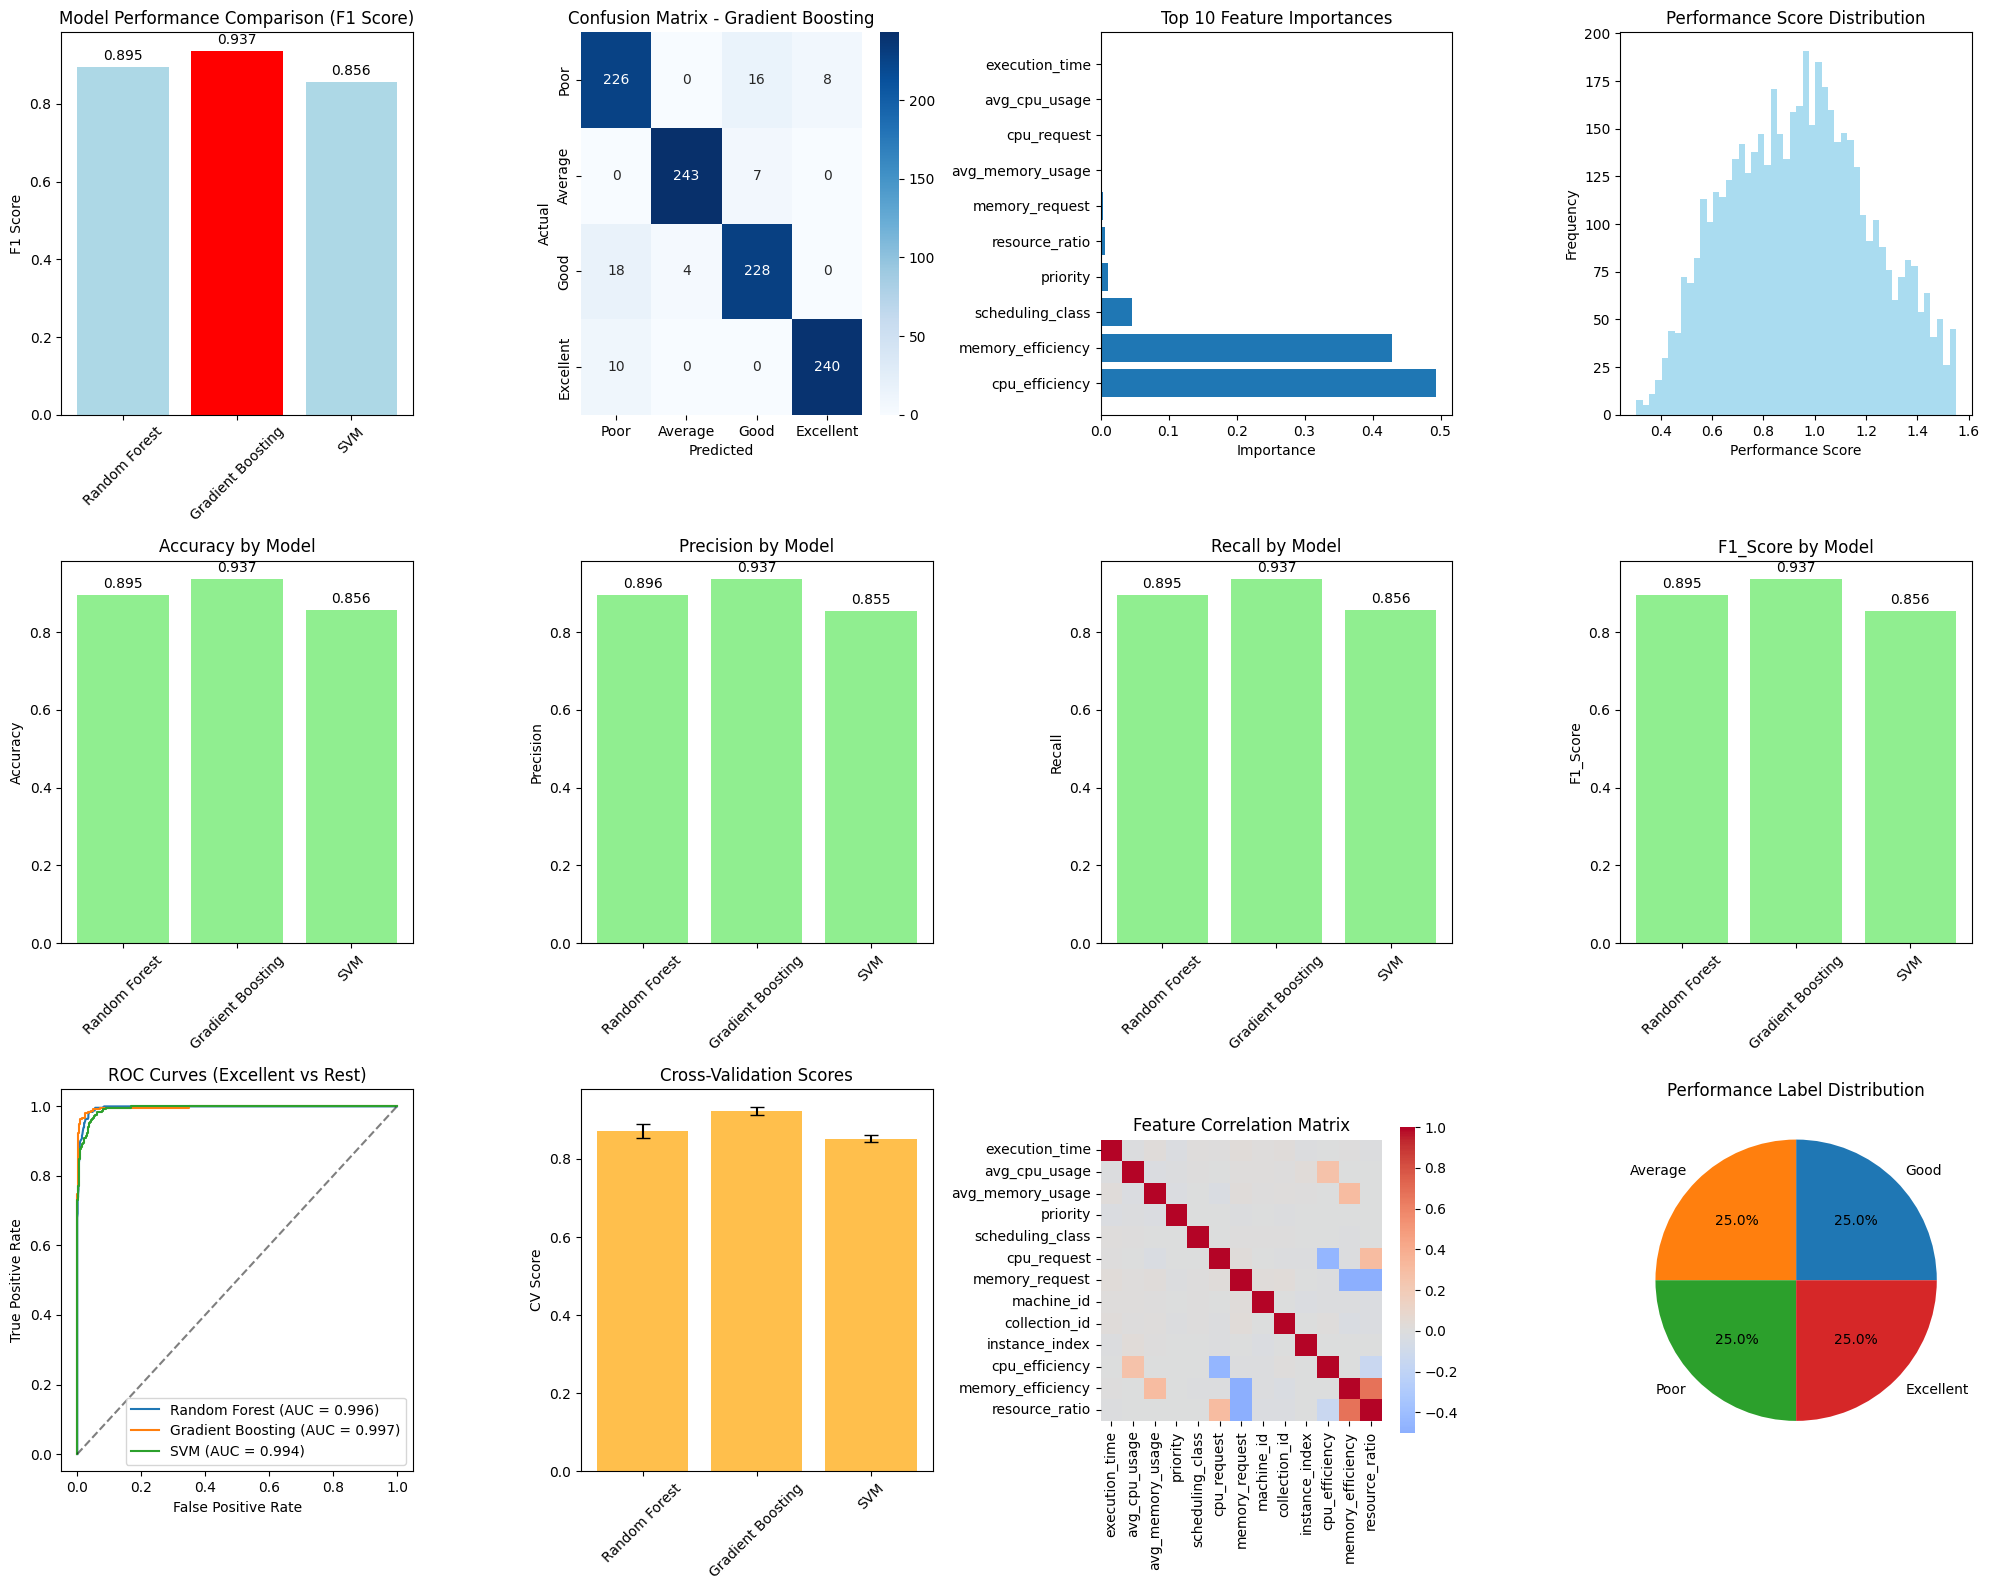


SCHEDULER EVALUATION: Hybrid_FAO_Demo
Predicted Performance: Good
Confidence: 0.5951
Model Used: Gradient Boosting


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                           confusion_matrix, classification_report, roc_curve, auc)
from sklearn.decomposition import PCA
from typing import List, Dict, Tuple, Optional
import warnings
warnings.filterwarnings('ignore')

class MLSchedulerEvaluator:
    """
    Machine Learning based scheduler performance evaluator using real scheduling data
    """

    def __init__(self, dataset_path: Optional[str] = None, dataset_df: Optional[pd.DataFrame] = None):
        self.dataset_df = dataset_df
        self.dataset_path = dataset_path
        self.scaler = StandardScaler()
        self.label_encoder = LabelEncoder()
        self.trained_models = {}
        self.feature_names = []
        self.performance_categories = ['Poor', 'Average', 'Good', 'Excellent']

        if dataset_df is not None:
            self.load_and_preprocess_data()

    def load_and_preprocess_data(self):
        """Load and preprocess the scheduling dataset"""
        if self.dataset_df is None:
            if self.dataset_path:
                self.dataset_df = pd.read_csv(self.dataset_path)
            else:
                raise ValueError("Either dataset_df or dataset_path must be provided")

        print(f"Dataset loaded with {len(self.dataset_df)} rows and {len(self.dataset_df.columns)} columns")

        # Extract relevant features for scheduling performance
        self.extract_scheduling_features()
        self.create_performance_labels()

    def extract_scheduling_features(self):
        """Extract relevant features from the scheduling dataset"""
        features_df = pd.DataFrame()

        # Time-based features
        if 'start_time' in self.dataset_df.columns and 'end_time' in self.dataset_df.columns:
            features_df['execution_time'] = pd.to_numeric(self.dataset_df['end_time'], errors='coerce') - pd.to_numeric(self.dataset_df['start_time'], errors='coerce')
        else:
            features_df['execution_time'] = 0

        # Resource utilization features
        if 'average_usage' in self.dataset_df.columns:
            # Parse CPU and memory usage from dictionary-like strings
            cpu_usage = []
            memory_usage = []
            for usage in self.dataset_df['average_usage']:
                try:
                    if isinstance(usage, str) and 'cpus' in usage:
                        # Extract CPU usage
                        cpu_start = usage.find("'cpus': ") + 8
                        cpu_end = usage.find(",", cpu_start)
                        if cpu_end == -1:
                            cpu_end = usage.find("}", cpu_start)
                        cpu_val = float(usage[cpu_start:cpu_end])
                        cpu_usage.append(cpu_val)

                        # Extract memory usage
                        mem_start = usage.find("'memory': ") + 10
                        mem_end = usage.find("}", mem_start)
                        mem_val = float(usage[mem_start:mem_end])
                        memory_usage.append(mem_val)
                    else:
                        cpu_usage.append(0)
                        memory_usage.append(0)
                except:
                    cpu_usage.append(0)
                    memory_usage.append(0)

            features_df['avg_cpu_usage'] = cpu_usage
            features_df['avg_memory_usage'] = memory_usage
        else:
            features_df['avg_cpu_usage'] = 0
            features_df['avg_memory_usage'] = 0

        # Priority and scheduling class
        features_df['priority'] = pd.to_numeric(self.dataset_df.get('priority', 0), errors='coerce').fillna(0)
        features_df['scheduling_class'] = pd.to_numeric(self.dataset_df.get('scheduling_class', 0), errors='coerce').fillna(0)

        # Resource requests
        if 'resource_request' in self.dataset_df.columns:
            cpu_requests = []
            memory_requests = []
            for req in self.dataset_df['resource_request']:
                try:
                    if isinstance(req, str) and 'cpus' in req:
                        cpu_start = req.find("'cpus': ") + 8
                        cpu_end = req.find(",", cpu_start)
                        if cpu_end == -1:
                            cpu_end = req.find("}", cpu_start)
                        cpu_val = float(req[cpu_start:cpu_end])
                        cpu_requests.append(cpu_val)

                        mem_start = req.find("'memory': ") + 10
                        mem_end = req.find("}", mem_start)
                        mem_val = float(req[mem_start:mem_end])
                        memory_requests.append(mem_val)
                    else:
                        cpu_requests.append(0)
                        memory_requests.append(0)
                except:
                    cpu_requests.append(0)
                    memory_requests.append(0)

            features_df['cpu_request'] = cpu_requests
            features_df['memory_request'] = memory_requests
        else:
            features_df['cpu_request'] = 0
            features_df['memory_request'] = 0

        # Machine and collection features
        features_df['machine_id'] = pd.to_numeric(self.dataset_df.get('machine_id', 0), errors='coerce').fillna(0)
        features_df['collection_id'] = pd.to_numeric(self.dataset_df.get('collection_id', 0), errors='coerce').fillna(0)
        features_df['instance_index'] = pd.to_numeric(self.dataset_df.get('instance_index', 0), errors='coerce').fillna(0)

        # Additional computed features
        features_df['cpu_efficiency'] = features_df['avg_cpu_usage'] / (features_df['cpu_request'] + 1e-10)
        features_df['memory_efficiency'] = features_df['avg_memory_usage'] / (features_df['memory_request'] + 1e-10)
        features_df['resource_ratio'] = features_df['cpu_request'] / (features_df['memory_request'] + 1e-10)

        # Handle infinite values
        features_df = features_df.replace([np.inf, -np.inf], np.nan).fillna(0)

        self.features_df = features_df
        self.feature_names = features_df.columns.tolist()

        print(f"Extracted {len(self.feature_names)} features: {self.feature_names}")

    def create_performance_labels(self):
        """Create performance labels based on scheduling metrics"""
        # Calculate composite performance score
        performance_scores = []

        for idx, row in self.features_df.iterrows():
            score = 0

            # CPU efficiency component (30%)
            cpu_eff = min(row['cpu_efficiency'], 2.0)  # Cap at 2.0 to avoid extreme values
            score += 0.3 * cpu_eff

            # Memory efficiency component (25%)
            mem_eff = min(row['memory_efficiency'], 2.0)
            score += 0.25 * mem_eff

            # Execution time component (25%) - normalized and inverted
            if row['execution_time'] > 0:
                exec_time_norm = 1.0 / (1.0 + row['execution_time'] / 1e12)  # Normalize large time values
                score += 0.25 * exec_time_norm

            # Priority consideration (10%)
            priority_norm = min(row['priority'] / 10.0, 1.0)  # Normalize priority
            score += 0.1 * priority_norm

            # Scheduling class bonus (10%)
            if row['scheduling_class'] in [2, 3]:  # Assuming these are better scheduling classes
                score += 0.1

            performance_scores.append(score)

        # Convert scores to categories using quartiles
        score_quartiles = np.percentile(performance_scores, [25, 50, 75])

        labels = []
        for score in performance_scores:
            if score <= score_quartiles[0]:
                labels.append('Poor')
            elif score <= score_quartiles[1]:
                labels.append('Average')
            elif score <= score_quartiles[2]:
                labels.append('Good')
            else:
                labels.append('Excellent')

        self.performance_scores = performance_scores
        self.performance_labels = labels

        # Print label distribution
        label_counts = pd.Series(labels).value_counts()
        print(f"\nPerformance label distribution:")
        for label, count in label_counts.items():
            print(f"  {label}: {count} ({count/len(labels)*100:.1f}%)")

    def train_classification_models(self):
        """Train multiple classification models"""
        X = self.features_df
        y = self.performance_labels

        # Encode labels
        y_encoded = self.label_encoder.fit_transform(y)

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
        )

        # Scale features
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)

        # Store test data for evaluation
        self.X_test = X_test_scaled
        self.y_test = y_test
        self.y_test_labels = self.label_encoder.inverse_transform(y_test)

        # Define models
        models = {
            'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
            'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
            'SVM': SVC(kernel='rbf', random_state=42, probability=True)
        }

        # Train and evaluate models
        model_results = {}

        for name, model in models.items():
            print(f"\nTraining {name}...")

            # Train model
            model.fit(X_train_scaled, y_train)

            # Cross-validation
            cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5)

            # Test predictions
            y_pred = model.predict(X_test_scaled)
            y_pred_proba = model.predict_proba(X_test_scaled) if hasattr(model, 'predict_proba') else None

            # Calculate metrics
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, average='weighted')
            recall = recall_score(y_test, y_pred, average='weighted')
            f1 = f1_score(y_test, y_pred, average='weighted')

            model_results[name] = {
                'model': model,
                'cv_mean': cv_scores.mean(),
                'cv_std': cv_scores.std(),
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1_score': f1,
                'y_pred': y_pred,
                'y_pred_proba': y_pred_proba,
                'confusion_matrix': confusion_matrix(y_test, y_pred)
            }

            print(f"  CV Score: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
            print(f"  Test Accuracy: {accuracy:.4f}")
            print(f"  Test F1: {f1:.4f}")

        self.trained_models = model_results

        # Select best model
        best_model_name = max(model_results.keys(), key=lambda x: model_results[x]['f1_score'])
        self.best_model_name = best_model_name
        self.best_model = model_results[best_model_name]['model']

        print(f"\nBest model: {best_model_name} (F1: {model_results[best_model_name]['f1_score']:.4f})")

        return model_results

    def evaluate_scheduler_performance(self, scheduler_mapping: List[int],
                                     scheduler_features: Dict[str, float],
                                     algorithm_name: str = "Custom_Scheduler"):
        """Evaluate a scheduler using the trained ML model"""
        if not self.trained_models:
            raise ValueError("Models not trained. Call train_classification_models() first.")

        # Prepare scheduler features
        feature_vector = np.zeros(len(self.feature_names))
        for i, feature_name in enumerate(self.feature_names):
            if feature_name in scheduler_features:
                feature_vector[i] = scheduler_features[feature_name]

        # Scale features
        feature_vector_scaled = self.scaler.transform(feature_vector.reshape(1, -1))

        # Get predictions from all models
        predictions = {}
        for model_name, model_data in self.trained_models.items():
            model = model_data['model']
            pred_class = model.predict(feature_vector_scaled)[0]
            pred_proba = model.predict_proba(feature_vector_scaled)[0] if hasattr(model, 'predict_proba') else None

            predictions[model_name] = {
                'predicted_class': self.label_encoder.inverse_transform([pred_class])[0],
                'predicted_probabilities': pred_proba,
                'confidence': max(pred_proba) if pred_proba is not None else None
            }

        # Use best model for final prediction
        best_prediction = predictions[self.best_model_name]

        return {
            'algorithm_name': algorithm_name,
            'predicted_performance': best_prediction['predicted_class'],
            'confidence': best_prediction['confidence'],
            'all_predictions': predictions,
            'feature_vector': scheduler_features,
            'model_used': self.best_model_name
        }

    def print_classification_results(self):
        """Print detailed classification results"""
        if not self.trained_models:
            print("No trained models available.")
            return

        print("\n" + "="*80)
        print("MACHINE LEARNING CLASSIFICATION RESULTS")
        print("="*80)

        # Model comparison table
        results_df = pd.DataFrame({
            'Model': list(self.trained_models.keys()),
            'CV Mean': [r['cv_mean'] for r in self.trained_models.values()],
            'CV Std': [r['cv_std'] for r in self.trained_models.values()],
            'Accuracy': [r['accuracy'] for r in self.trained_models.values()],
            'Precision': [r['precision'] for r in self.trained_models.values()],
            'Recall': [r['recall'] for r in self.trained_models.values()],
            'F1 Score': [r['f1_score'] for r in self.trained_models.values()]
        })

        print("\nModel Performance Comparison:")
        print(results_df.round(4).to_string(index=False))

        # Best model details
        best_results = self.trained_models[self.best_model_name]
        print(f"\nBest Model: {self.best_model_name}")
        print(f"Test Set Performance:")
        print(f"  Accuracy:  {best_results['accuracy']:.4f}")
        print(f"  Precision: {best_results['precision']:.4f}")
        print(f"  Recall:    {best_results['recall']:.4f}")
        print(f"  F1 Score:  {best_results['f1_score']:.4f}")

        # Classification report
        y_pred_labels = self.label_encoder.inverse_transform(best_results['y_pred'])
        print(f"\nDetailed Classification Report ({self.best_model_name}):")
        print(classification_report(self.y_test_labels, y_pred_labels))

        # Feature importance (for tree-based models)
        if hasattr(best_results['model'], 'feature_importances_'):
            feature_importance = pd.DataFrame({
                'Feature': self.feature_names,
                'Importance': best_results['model'].feature_importances_
            }).sort_values('Importance', ascending=False)

            print(f"\nTop 10 Most Important Features ({self.best_model_name}):")
            print(feature_importance.head(10).to_string(index=False))

    def visualize_classification_results(self):
        """Create comprehensive visualizations"""
        if not self.trained_models:
            print("No trained models to visualize.")
            return

        fig = plt.figure(figsize=(20, 16))

        # 1. Model Performance Comparison
        plt.subplot(3, 4, 1)
        models = list(self.trained_models.keys())
        f1_scores = [self.trained_models[m]['f1_score'] for m in models]

        bars = plt.bar(models, f1_scores, color=['red' if m == self.best_model_name else 'lightblue' for m in models])
        plt.title('Model Performance Comparison (F1 Score)')
        plt.ylabel('F1 Score')
        plt.xticks(rotation=45)

        # Highlight best model
        for i, (model, score) in enumerate(zip(models, f1_scores)):
            plt.text(i, score + 0.01, f'{score:.3f}', ha='center', va='bottom')

        # 2. Confusion Matrix for Best Model
        plt.subplot(3, 4, 2)
        best_cm = self.trained_models[self.best_model_name]['confusion_matrix']
        sns.heatmap(best_cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=self.performance_categories,
                   yticklabels=self.performance_categories)
        plt.title(f'Confusion Matrix - {self.best_model_name}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')

        # 3. Feature Importance (if available)
        plt.subplot(3, 4, 3)
        if hasattr(self.trained_models[self.best_model_name]['model'], 'feature_importances_'):
            importances = self.trained_models[self.best_model_name]['model'].feature_importances_
            indices = np.argsort(importances)[::-1][:10]

            plt.barh(range(10), importances[indices])
            plt.yticks(range(10), [self.feature_names[i] for i in indices])
            plt.title('Top 10 Feature Importances')
            plt.xlabel('Importance')

        # 4. Performance Score Distribution
        plt.subplot(3, 4, 4)
        plt.hist(self.performance_scores, bins=50, alpha=0.7, color='skyblue')
        plt.title('Performance Score Distribution')
        plt.xlabel('Performance Score')
        plt.ylabel('Frequency')

        # 5-8. Class-wise Performance Analysis
        for i, metric in enumerate(['accuracy', 'precision', 'recall', 'f1_score']):
            plt.subplot(3, 4, 5+i)
            values = [self.trained_models[m][metric] for m in models]
            plt.bar(models, values, color='lightgreen')
            plt.title(f'{metric.title()} by Model')
            plt.ylabel(metric.title())
            plt.xticks(rotation=45)

            for j, v in enumerate(values):
                plt.text(j, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

        # 9. ROC Curves (if probabilities available)
        plt.subplot(3, 4, 9)
        for model_name, model_data in self.trained_models.items():
            if model_data['y_pred_proba'] is not None:
                # For multiclass, plot ROC for each class
                y_test_bin = (self.y_test == 3).astype(int)  # Example: Excellent vs Rest
                y_pred_proba_bin = model_data['y_pred_proba'][:, 3]  # Probability of Excellent

                fpr, tpr, _ = roc_curve(y_test_bin, y_pred_proba_bin)
                roc_auc = auc(fpr, tpr)

                plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.3f})')

        plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves (Excellent vs Rest)')
        plt.legend()

        # 10. Cross-validation Scores
        plt.subplot(3, 4, 10)
        cv_means = [self.trained_models[m]['cv_mean'] for m in models]
        cv_stds = [self.trained_models[m]['cv_std'] for m in models]

        plt.bar(models, cv_means, yerr=cv_stds, capsize=5, color='orange', alpha=0.7)
        plt.title('Cross-Validation Scores')
        plt.ylabel('CV Score')
        plt.xticks(rotation=45)

        # 11. Feature Correlation Matrix
        plt.subplot(3, 4, 11)
        correlation_matrix = self.features_df.corr()
        sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0,
                   square=True, cbar_kws={'shrink': 0.8})
        plt.title('Feature Correlation Matrix')

        # 12. Label Distribution
        plt.subplot(3, 4, 12)
        label_counts = pd.Series(self.performance_labels).value_counts()
        plt.pie(label_counts.values, labels=label_counts.index, autopct='%1.1f%%')
        plt.title('Performance Label Distribution')

        plt.tight_layout()
        plt.show()

# Integration function for your existing scheduler
def evaluate_scheduler_with_ml(dataset_df, scheduler_mapping, scheduler_metrics, algorithm_name="Hybrid_FAO"):
    """
    Enhanced evaluation function using ML classification

    Args:
        dataset_df: Your scheduling dataset
        scheduler_mapping: List of VM assignments for tasks
        scheduler_metrics: Dict with scheduler performance metrics
        algorithm_name: Name of your scheduler algorithm
    """
    # Initialize evaluator
    evaluator = MLSchedulerEvaluator(dataset_df=dataset_df)

    # Train models
    print("Training ML models for scheduler performance classification...")
    model_results = evaluator.train_classification_models()

    # Print results
    evaluator.print_classification_results()

    # Visualize results
    evaluator.visualize_classification_results()

    # Evaluate your scheduler
    scheduler_prediction = evaluator.evaluate_scheduler_performance(
        scheduler_mapping, scheduler_metrics, algorithm_name
    )

    print(f"\n" + "="*60)
    print(f"SCHEDULER EVALUATION: {algorithm_name}")
    print("="*60)
    print(f"Predicted Performance: {scheduler_prediction['predicted_performance']}")
    print(f"Confidence: {scheduler_prediction['confidence']:.4f}")
    print(f"Model Used: {scheduler_prediction['model_used']}")

    return {
        'model_results': model_results,
        'scheduler_prediction': scheduler_prediction,
        'evaluator': evaluator
    }

# Demo function with sample data structure
def demo_ml_evaluation():
    """Demo with sample data that matches your dataset structure"""
    # Create sample data matching your dataset structure
    np.random.seed(42)
    n_samples = 5000

    sample_data = {
        'time': np.random.randint(0, 1000, n_samples),
        'instance_events_type': np.random.randint(0, 3, n_samples),
        'collection_id': np.random.randint(0, 1000, n_samples),
        'scheduling_class': np.random.randint(0, 4, n_samples),
        'priority': np.random.randint(0, 11, n_samples),
        'machine_id': np.random.randint(0, 500, n_samples),
        'start_time': np.random.randint(0, 1000000, n_samples),
        'end_time': np.random.randint(1000000, 2000000, n_samples),
        'average_usage': [f"{{'cpus': {np.random.uniform(0, 0.1):.6f}, 'memory': {np.random.uniform(0, 0.05):.6f}}}"
                         for _ in range(n_samples)],
        'resource_request': [f"{{'cpus': {np.random.uniform(0.001, 0.1):.6f}, 'memory': {np.random.uniform(0.001, 0.05):.6f}}}"
                            for _ in range(n_samples)],
        'instance_index': np.random.randint(0, 100, n_samples),
    }

    sample_df = pd.DataFrame(sample_data)

    # Sample scheduler results
    scheduler_mapping = np.random.randint(0, 10, 1000).tolist()
    scheduler_metrics = {
        'execution_time': 150000,
        'avg_cpu_usage': 0.045,
        'avg_memory_usage': 0.025,
        'priority': 5,
        'scheduling_class': 2,
        'cpu_request': 0.03,
        'memory_request': 0.02,
        'machine_id': 150,
        'collection_id': 500,
        'instance_index': 50,
        'cpu_efficiency': 1.5,
        'memory_efficiency': 1.25,
        'resource_ratio': 1.5
    }

    # Run evaluation
    results = evaluate_scheduler_with_ml(
        sample_df, scheduler_mapping, scheduler_metrics, "Hybrid_FAO_Demo"
    )

    return results

if __name__ == "__main__":
    print("Enhanced ML-Based Scheduler Performance Evaluation")
    print("="*60)
    demo_results = demo_ml_evaluation()

Google Cluster Scheduling: Comprehensive Algorithm Evaluation
Detected headers in CSV file
Error loading CSV file: arg must be a list, tuple, 1-d array, or Series
Creating sample data...

=== Generating Ground Truth (Greedy Algorithm) ===
Generated ground truth with 19 different VM assignments
Initialized GoogleClusterScheduler with 100 tasks and 19 VMs
COMPREHENSIVE ALGORITHM EVALUATION

=== Running Firefly Algorithm ===
FA Generation 0: Best fitness = 0.170
FA Generation 10: Best fitness = 0.170
FA Generation 20: Best fitness = 0.170
FA Generation 30: Best fitness = 0.170
FA Generation 40: Best fitness = 0.170

=== Running Antlion Optimizer ===
ALO Generation 0: Best fitness = 0.197
ALO Generation 10: Best fitness = 0.159
ALO Generation 20: Best fitness = 0.150
ALO Generation 30: Best fitness = 0.134
ALO Generation 40: Best fitness = 0.127

=== Running Hybrid FA+ALO Algorithm ===
Completed Firefly phase, starting Antlion phase...

CLASSIFICATION METRICS COMPARISON

FIREFLY ALGORITHM 

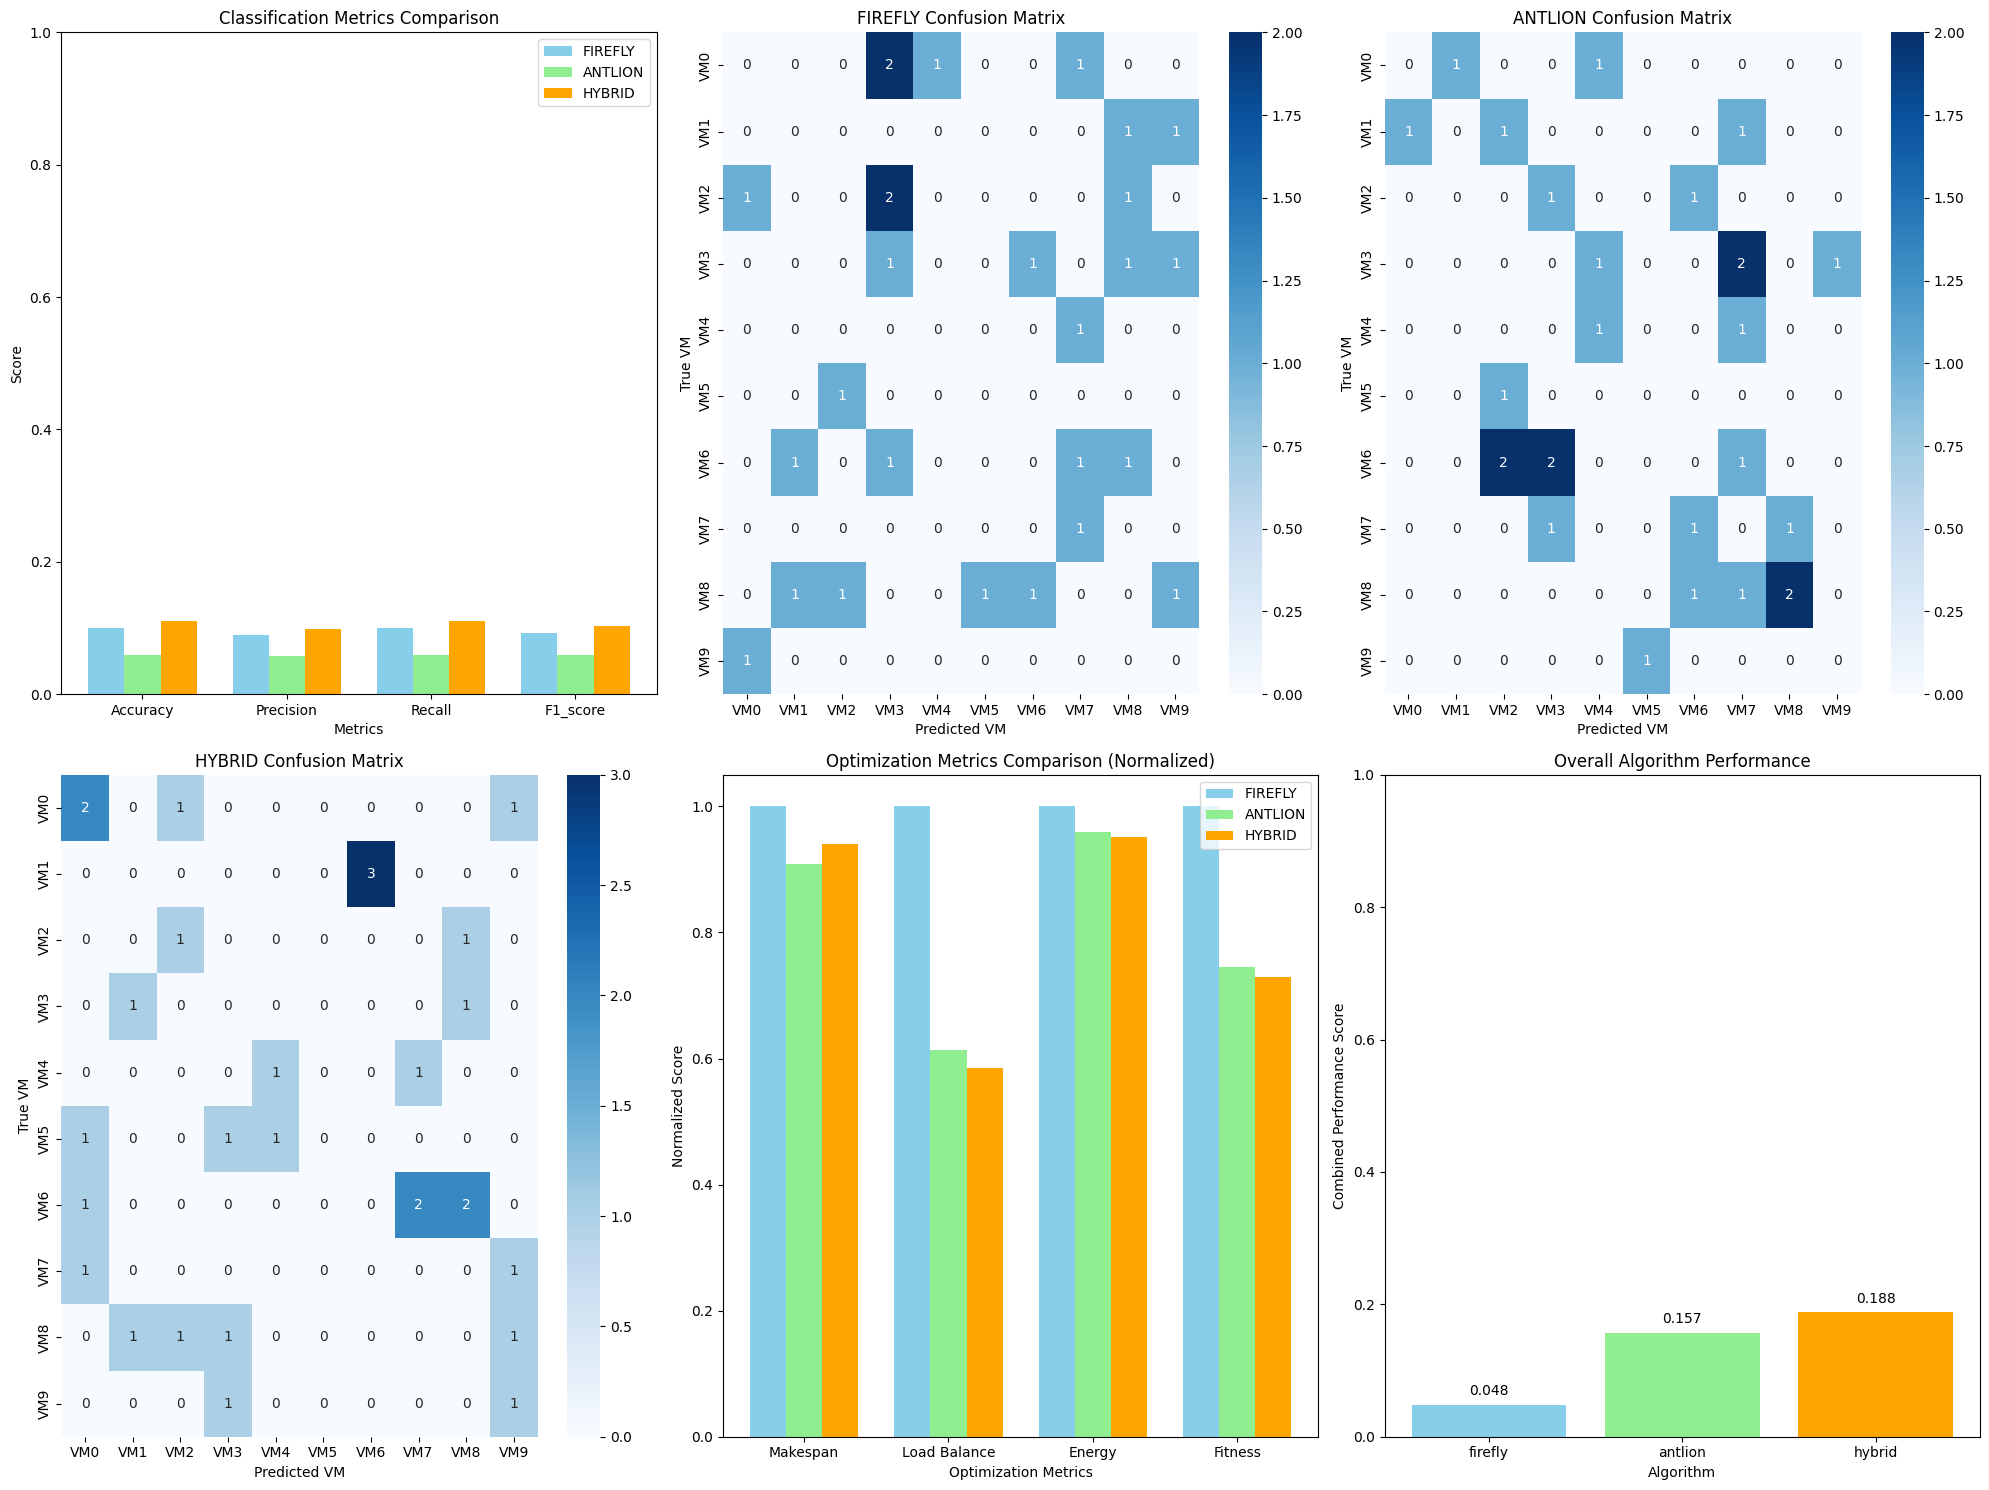


DETAILED COMPARISON TABLE
Algorithm Accuracy Precision Recall F1-Score Makespan Load Balance Energy (kW) Fitness
  FIREFLY   0.1000    0.0889 0.1000   0.0931    0.255        0.340       1.569   0.170
  ANTLION   0.0600    0.0579 0.0600   0.0585    0.232        0.209       1.506   0.127
   HYBRID   0.1100    0.0993 0.1100   0.1027    0.240        0.199       1.493   0.124

BEST ALGORITHM PER METRIC
Accuracy............ HYBRID (0.1100)
Precision........... HYBRID (0.0993)
Recall.............. HYBRID (0.1100)
F1_score............ HYBRID (0.1027)
Makespan............ ANTLION (0.232)
Load Balance........ HYBRID (0.199)
Energy.............. HYBRID (1.493 kW)
Fitness............. HYBRID (0.124)

Results saved to algorithm_comparison_results.csv

EVALUATION SUMMARY

🏆 BEST OVERALL ALGORITHM: HYBRID
📊 Combined Score: 0.1867

📈 CLASSIFICATION METRICS (Best HYBRID):
   • Accuracy:  0.1100
   • Precision: 0.0993
   • Recall:    0.1100
   • F1-Score:  0.1027

⚡ OPTIMIZATION METRICS (Best HYBRID):


In [ ]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import List, Tuple, Dict
import copy
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

@dataclass
class Task:
    """Represents a task with its properties extracted from Google cluster trace"""
    id: int
    length: float  # CPU usage or workload (normalized)
    arrival_time: int = 0
    priority: int = 0
    cpu_request: float = 0.0
    memory_request: float = 0.0
    collection_id: int = 0
    scheduling_class: int = 0

@dataclass
class VirtualMachine:
    """Represents a VM with its properties"""
    id: int
    mips: float  # Processing capacity (normalized)
    power_idle: float  # Power consumption when idle (watts)
    power_busy: float  # Power consumption when busy (watts)
    is_active: bool = True
    cpu_capacity: float = 1.0
    memory_capacity: float = 1.0

class GoogleClusterSchedulerWithMetrics:
    """Enhanced Cloud scheduler with classification metrics evaluation"""

    def __init__(self, csv_file_path: str, alpha=0.4, beta=0.3, gamma=0.3, load_threshold=0.1, max_tasks=1000):
        # Load and preprocess the data
        self.df = self.load_cluster_data(csv_file_path, max_tasks)
        self.tasks = self.create_tasks_from_data()
        self.vms = self.create_vms_from_data()

        self.n_tasks = len(self.tasks)
        self.n_vms = len(self.vms)

        # Fitness function weights
        self.alpha = alpha  # Makespan weight
        self.beta = beta    # Load balance weight
        self.gamma = gamma  # Energy weight

        # Load balancing parameters
        self.load_threshold = load_threshold
        self.idle_threshold = 10  # Time units before considering VM for shutdown

        # Algorithm parameters
        self.max_generations = 50  # Reduced for large datasets
        self.population_size = 20  # Reduced for performance
        self.firefly_pop = []

        # Store results for comparison
        self.results = {
            'firefly': None,
            'antlion': None,
            'hybrid': None
        }

        # Generate ground truth (optimal or baseline scheduling)
        self.ground_truth = self.generate_ground_truth()

        print(f"Initialized GoogleClusterScheduler with {self.n_tasks} tasks and {self.n_vms} VMs")

    def load_cluster_data(self, csv_file_path: str, max_tasks: int) -> pd.DataFrame:
        """Load and preprocess Google cluster trace data"""
        try:
            # First, try to detect if the file has headers
            sample_df = pd.read_csv(csv_file_path, nrows=1)
            has_headers = any('time' in str(col).lower() or 'collection' in str(col).lower()
                            for col in sample_df.columns)

            if has_headers:
                # Load with existing headers
                print("Detected headers in CSV file")
                df = pd.read_csv(csv_file_path, nrows=max_tasks)

                # Map common column variations to standard names
                column_mapping = {}
                for col in df.columns:
                    col_lower = str(col).lower().strip()
                    if 'time' in col_lower and 'start' not in col_lower and 'end' not in col_lower:
                        column_mapping[col] = 'time'
                    elif 'collection_id' in col_lower:
                        column_mapping[col] = 'collection_id'
                    elif 'machine_id' in col_lower:
                        column_mapping[col] = 'machine_id'
                    elif 'scheduling_class' in col_lower:
                        column_mapping[col] = 'scheduling_class'
                    elif 'priority' in col_lower:
                        column_mapping[col] = 'priority'
                    elif 'resource_request' in col_lower:
                        column_mapping[col] = 'resource_request'
                    elif 'start_time' in col_lower:
                        column_mapping[col] = 'start_time'
                    elif 'end_time' in col_lower:
                        column_mapping[col] = 'end_time'

                df = df.rename(columns=column_mapping)

            else:
                # Load without headers and assign column names
                print("No headers detected, assigning column names")
                columns = [
                    'time', 'instance_events_type', 'collection_id', 'scheduling_class',
                    'collection_type', 'priority', 'alloc_collection_id', 'instance_index',
                    'machine_id', 'resource_request', 'constraint', 'collections_events_type',
                    'user', 'collection_name', 'collection_logical_name', 'start_after_collection_ids',
                    'vertical_scaling', 'scheduler', 'start_time', 'end_time', 'average_usage',
                    'maximum_usage', 'random_sample_usage', 'assigned_memory', 'page_cache_memory',
                    'cycles_per_instruction', 'memory_accesses_per_instruction', 'sample_rate',
                    'cpu_usage_distribution', 'tail_cpu_usage_distribution', 'cluster', 'event', 'failed'
                ]

                df = pd.read_csv(csv_file_path, names=columns, nrows=max_tasks)

            # Clean and preprocess data
            numeric_columns = ['collection_id', 'machine_id', 'priority', 'scheduling_class', 'time']
            for col in numeric_columns:
                if col in df.columns:
                    df[col] = pd.to_numeric(df[col], errors='coerce')

            # Remove rows where essential columns are NaN
            essential_cols = [col for col in ['machine_id', 'collection_id'] if col in df.columns]
            if essential_cols:
                df = df.dropna(subset=essential_cols)
            df = df.reset_index(drop=True)

            # Parse resource_request if it exists
            if 'resource_request' in df.columns:
                df['cpu_request'] = 0.001
                df['memory_request'] = 0.001

                for idx, row in df.iterrows():
                    try:
                        resource_val = row['resource_request']
                        if pd.notna(resource_val) and isinstance(resource_val, str):
                            if 'cpus' in resource_val:
                                cpu_start = resource_val.find("'cpus': ") + 8
                                if cpu_start > 7:
                                    cpu_end = resource_val.find(",", cpu_start)
                                    if cpu_end == -1:
                                        cpu_end = resource_val.find("}", cpu_start)
                                    if cpu_end > cpu_start:
                                        cpu_str = resource_val[cpu_start:cpu_end].strip()
                                        df.loc[idx, 'cpu_request'] = float(cpu_str)

                            if 'memory' in resource_val:
                                memory_start = resource_val.find("'memory': ") + 10
                                if memory_start > 9:
                                    memory_end = resource_val.find("}", memory_start)
                                    if memory_end > memory_start:
                                        memory_str = resource_val[memory_start:memory_end].strip()
                                        if memory_str != 'None' and memory_str:
                                            df.loc[idx, 'memory_request'] = float(memory_str)
                        elif pd.notna(resource_val) and isinstance(resource_val, (int, float)):
                            df.loc[idx, 'cpu_request'] = float(resource_val)
                    except Exception as e:
                        continue
            else:
                df['cpu_request'] = np.random.uniform(0.001, 0.1, len(df))
                df['memory_request'] = np.random.uniform(0.001, 0.05, len(df))

            # Ensure essential columns exist with defaults
            if 'priority' not in df.columns:
                df['priority'] = np.random.randint(0, 12, len(df))
            if 'scheduling_class' not in df.columns:
                df['scheduling_class'] = np.random.randint(0, 4, len(df))
            if 'start_time' not in df.columns:
                df['start_time'] = np.random.randint(0, 1000, len(df))
            if 'end_time' not in df.columns:
                df['end_time'] = df['start_time'] + np.random.randint(100, 2000, len(df))
            if 'machine_id' not in df.columns:
                df['machine_id'] = np.random.randint(0, 50, len(df))
            if 'collection_id' not in df.columns:
                df['collection_id'] = range(len(df))

            print(f"Loaded {len(df)} records from cluster trace data")
            return df
        except Exception as e:
            print(f"Error loading CSV file: {e}")
            return self.create_sample_dataframe(max_tasks)

    def create_sample_dataframe(self, max_tasks: int) -> pd.DataFrame:
        """Create sample dataframe if CSV loading fails"""
        print("Creating sample data...")
        data = []
        for i in range(min(max_tasks, 100)):
            data.append({
                'collection_id': i,
                'machine_id': random.randint(0, 19),
                'cpu_request': random.uniform(0.001, 0.1),
                'memory_request': random.uniform(0.001, 0.05),
                'priority': random.randint(0, 11),
                'scheduling_class': random.randint(0, 3),
                'start_time': random.randint(0, 1000),
                'end_time': random.randint(1001, 2000)
            })
        return pd.DataFrame(data)

    def create_tasks_from_data(self) -> List[Task]:
        """Create Task objects from loaded data"""
        tasks = []

        for idx, row in self.df.iterrows():
            length = max(row.get('cpu_request', 0.001), 0.001)
            length *= 1000

            task = Task(
                id=idx,
                length=length,
                arrival_time=int(row.get('start_time', 0)),
                priority=int(row.get('priority', 0)),
                cpu_request=row.get('cpu_request', 0.001),
                memory_request=row.get('memory_request', 0.001),
                collection_id=int(row.get('collection_id', 0)),
                scheduling_class=int(row.get('scheduling_class', 0))
            )
            tasks.append(task)

        return tasks

    def create_vms_from_data(self) -> List[VirtualMachine]:
        """Create VM objects based on unique machines in data"""
        unique_machines = self.df['machine_id'].unique()
        vms = []

        for i, machine_id in enumerate(unique_machines[:20]):
            base_mips = 1000 + (hash(str(machine_id)) % 1000)

            vm = VirtualMachine(
                id=i,
                mips=base_mips,
                power_idle=80 + (i * 10),
                power_busy=200 + (i * 20),
                cpu_capacity=0.8 + (i % 5) * 0.05,
                memory_capacity=0.7 + (i % 6) * 0.05
            )
            vms.append(vm)

        return vms

    def generate_ground_truth(self) -> List[int]:
        """Generate ground truth using a simple greedy algorithm based on task characteristics"""
        print("\n=== Generating Ground Truth (Greedy Algorithm) ===")
        ground_truth = []

        # Sort tasks by priority and CPU requirement
        task_indices = sorted(range(len(self.tasks)),
                            key=lambda i: (self.tasks[i].priority, -self.tasks[i].cpu_request))

        vm_loads = [0.0] * self.n_vms

        for task_idx in task_indices:
            task = self.tasks[task_idx]

            # Find VM with minimum load that can handle the task
            best_vm = min(range(self.n_vms), key=lambda vm_idx: vm_loads[vm_idx])

            # Alternative: Find VM with best fit based on capacity
            suitable_vms = [vm_idx for vm_idx in range(self.n_vms)
                          if self.vms[vm_idx].cpu_capacity >= task.cpu_request and
                             self.vms[vm_idx].memory_capacity >= task.memory_request]

            if suitable_vms:
                best_vm = min(suitable_vms, key=lambda vm_idx: vm_loads[vm_idx])

            ground_truth.append(best_vm)
            vm_loads[best_vm] += task.length / self.vms[best_vm].mips

        # Reorder to match original task order
        ordered_ground_truth = [0] * len(self.tasks)
        for i, task_idx in enumerate(task_indices):
            ordered_ground_truth[task_idx] = ground_truth[i]

        print(f"Generated ground truth with {len(set(ordered_ground_truth))} different VM assignments")
        return ordered_ground_truth

    def initialize_population(self):
        """Initialize Firefly population"""
        self.firefly_pop = []
        for i in range(self.population_size):
            mapping = [random.randint(0, self.n_vms - 1) for _ in range(self.n_tasks)]
            fitness = self.calculate_fitness(mapping)

            firefly = {
                'mapping': mapping,
                'fitness': fitness,
                'brightness': 1.0 / (1.0 + fitness)
            }
            self.firefly_pop.append(firefly)

        self.firefly_pop.sort(key=lambda x: x['fitness'])

    def calculate_fitness(self, mapping: List[int]) -> float:
        """Calculate fitness based on makespan, load balance, and energy consumption"""
        makespan = self.calculate_makespan(mapping)
        load_balance_index = self.calculate_load_balance_index(mapping)
        energy_consumption = self.calculate_energy_consumption(mapping)

        max_possible_makespan = sum(task.length for task in self.tasks) / min(vm.mips for vm in self.vms)
        normalized_makespan = makespan / max_possible_makespan if max_possible_makespan > 0 else 0

        fitness = (self.alpha * normalized_makespan +
                  self.beta * load_balance_index +
                  self.gamma * energy_consumption / 10000)

        return fitness

    def calculate_makespan(self, mapping: List[int]) -> float:
        """Calculate makespan for given task-VM mapping"""
        vm_completion_times = [0.0] * self.n_vms

        for task_idx, vm_idx in enumerate(mapping):
            if vm_idx < self.n_vms and task_idx < len(self.tasks):
                execution_time = self.tasks[task_idx].length / self.vms[vm_idx].mips
                vm_completion_times[vm_idx] += execution_time

        return max(vm_completion_times) if vm_completion_times else 0.0

    def calculate_load_balance_index(self, mapping: List[int]) -> float:
        """Calculate load balance index"""
        vm_loads = [0.0] * self.n_vms

        for task_idx, vm_idx in enumerate(mapping):
            if vm_idx < self.n_vms and task_idx < len(self.tasks):
                vm_loads[vm_idx] += self.tasks[task_idx].length / self.vms[vm_idx].mips

        if len(vm_loads) == 0:
            return 0.0

        mean_load = np.mean(vm_loads)
        if mean_load == 0:
            return 0.0

        return np.std(vm_loads) / mean_load

    def calculate_energy_consumption(self, mapping: List[int]) -> float:
        """Calculate total energy consumption"""
        vm_busy_times = [0.0] * self.n_vms

        for task_idx, vm_idx in enumerate(mapping):
            if vm_idx < self.n_vms and task_idx < len(self.tasks):
                execution_time = self.tasks[task_idx].length / self.vms[vm_idx].mips
                vm_busy_times[vm_idx] += execution_time

        total_energy = 0.0
        makespan = max(vm_busy_times) if vm_busy_times else 0.0

        for vm_idx, busy_time in enumerate(vm_busy_times):
            idle_time = max(0, makespan - busy_time)
            energy = (busy_time * self.vms[vm_idx].power_busy +
                     idle_time * self.vms[vm_idx].power_idle)
            total_energy += energy

        return total_energy

    def run_firefly_algorithm(self) -> List[int]:
        """Run standalone Firefly Algorithm"""
        print("\n=== Running Firefly Algorithm ===")
        self.initialize_population()

        for generation in range(self.max_generations):
            for i in range(self.population_size):
                for j in range(self.population_size):
                    if self.firefly_pop[j]['brightness'] > self.firefly_pop[i]['brightness']:
                        self.move_firefly(i, j)

            for firefly in self.firefly_pop:
                firefly['brightness'] = 1.0 / (1.0 + firefly['fitness'])

            self.firefly_pop.sort(key=lambda x: x['fitness'])

            if generation % 10 == 0:
                print(f"FA Generation {generation}: Best fitness = {self.firefly_pop[0]['fitness']:.3f}")

        return self.firefly_pop[0]['mapping']

    def move_firefly(self, i: int, j: int):
        """Move firefly i toward brighter firefly j"""
        beta0 = 1.0
        gamma_fa = 0.1
        alpha_fa = 0.2

        distance = sum(1 for x, y in zip(self.firefly_pop[i]['mapping'],
                                        self.firefly_pop[j]['mapping']) if x != y)
        distance = distance / self.n_tasks if self.n_tasks > 0 else 0

        beta = beta0 * np.exp(-gamma_fa * distance * distance)

        new_mapping = []
        for k in range(self.n_tasks):
            if random.random() < beta:
                new_mapping.append(self.firefly_pop[j]['mapping'][k])
            elif random.random() < alpha_fa:
                new_mapping.append(random.randint(0, self.n_vms - 1))
            else:
                new_mapping.append(self.firefly_pop[i]['mapping'][k])

        new_fitness = self.calculate_fitness(new_mapping)
        if new_fitness < self.firefly_pop[i]['fitness']:
            self.firefly_pop[i]['mapping'] = new_mapping
            self.firefly_pop[i]['fitness'] = new_fitness

    def run_antlion_optimizer(self) -> List[int]:
        """Run standalone Antlion Optimizer"""
        print("\n=== Running Antlion Optimizer ===")

        # Initialize antlions randomly
        n_antlions = self.population_size // 2
        antlions = []
        for i in range(n_antlions):
            mapping = [random.randint(0, self.n_vms - 1) for _ in range(self.n_tasks)]
            fitness = self.calculate_fitness(mapping)
            antlions.append({'mapping': mapping, 'fitness': fitness})

        antlions.sort(key=lambda x: x['fitness'])
        elite_antlion = copy.deepcopy(antlions[0])

        for generation in range(self.max_generations):
            for ant_idx in range(n_antlions):
                new_mapping = self.random_walk_ant(antlions[ant_idx])
                new_fitness = self.calculate_fitness(new_mapping)

                if new_fitness < antlions[ant_idx]['fitness']:
                    antlions[ant_idx]['mapping'] = new_mapping
                    antlions[ant_idx]['fitness'] = new_fitness

                    if new_fitness < elite_antlion['fitness']:
                        elite_antlion = copy.deepcopy(antlions[ant_idx])

            if generation % 10 == 0:
                print(f"ALO Generation {generation}: Best fitness = {elite_antlion['fitness']:.3f}")

        return elite_antlion['mapping']

    def random_walk_ant(self, antlion: dict) -> List[int]:
        """Perform random walk for ant around antlion"""
        mapping = antlion['mapping'].copy()
        n_changes = random.randint(1, max(1, self.n_tasks // 10))

        for _ in range(n_changes):
            task_idx = random.randint(0, self.n_tasks - 1)
            current_vm = mapping[task_idx]
            step = random.randint(-2, 2)
            new_vm = max(0, min(self.n_vms - 1, current_vm + step))
            mapping[task_idx] = new_vm

        return mapping

    def run_hybrid_algorithm(self) -> List[int]:
        """Run hybrid FA+ALO algorithm"""
        print("\n=== Running Hybrid FA+ALO Algorithm ===")

        # Phase 1: Firefly Algorithm
        self.initialize_population()

        for generation in range(self.max_generations // 2):
            for i in range(self.population_size):
                for j in range(self.population_size):
                    if self.firefly_pop[j]['brightness'] > self.firefly_pop[i]['brightness']:
                        self.move_firefly(i, j)

            for firefly in self.firefly_pop:
                firefly['brightness'] = 1.0 / (1.0 + firefly['fitness'])

            self.firefly_pop.sort(key=lambda x: x['fitness'])

        print("Completed Firefly phase, starting Antlion phase...")

        # Phase 2: Antlion Optimizer
        n_antlions = max(1, self.population_size // 2)
        antlions = self.firefly_pop[:n_antlions]
        elite_antlion = copy.deepcopy(self.firefly_pop[0])

        for generation in range(self.max_generations // 2):
            for ant_idx in range(n_antlions):
                new_mapping = self.random_walk_ant(antlions[ant_idx])
                new_fitness = self.calculate_fitness(new_mapping)

                if new_fitness < antlions[ant_idx]['fitness']:
                    antlions[ant_idx]['mapping'] = new_mapping
                    antlions[ant_idx]['fitness'] = new_fitness

                    if new_fitness < elite_antlion['fitness']:
                        elite_antlion = copy.deepcopy(antlions[ant_idx])

        return elite_antlion['mapping']

    def calculate_classification_metrics(self, predicted: List[int], ground_truth: List[int], algorithm_name: str):
        """Calculate classification metrics"""
        # Convert to numpy arrays
        y_true = np.array(ground_truth)
        y_pred = np.array(predicted)

        # Calculate metrics
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
        recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

        # Confusion matrix
        cm = confusion_matrix(y_true, y_pred)

        return {
            'algorithm': algorithm_name,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'confusion_matrix': cm
        }

    def run_complete_evaluation(self):
        """Run all algorithms and calculate comprehensive metrics"""
        print("=" * 80)
        print("COMPREHENSIVE ALGORITHM EVALUATION")
        print("=" * 80)

        # Run all algorithms
        firefly_result = self.run_firefly_algorithm()
        antlion_result = self.run_antlion_optimizer()
        hybrid_result = self.run_hybrid_algorithm()

        # Store results
        self.results['firefly'] = firefly_result
        self.results['antlion'] = antlion_result
        self.results['hybrid'] = hybrid_result

        # Calculate classification metrics for each algorithm
        metrics = {}

        print("\n" + "=" * 60)
        print("CLASSIFICATION METRICS COMPARISON")
        print("=" * 60)

        for alg_name, result in self.results.items():
            metrics[alg_name] = self.calculate_classification_metrics(
                result, self.ground_truth, alg_name.upper()
            )

            print(f"\n{alg_name.upper()} ALGORITHM METRICS:")
            print("-" * 40)
            print(f"Accuracy:  {metrics[alg_name]['accuracy']:.4f}")
            print(f"Precision: {metrics[alg_name]['precision']:.4f}")
            print(f"Recall:    {metrics[alg_name]['recall']:.4f}")
            print(f"F1-Score:  {metrics[alg_name]['f1_score']:.4f}")

        # Calculate optimization metrics
        print("\n" + "=" * 60)
        print("OPTIMIZATION METRICS COMPARISON")
        print("=" * 60)

        for alg_name, result in self.results.items():
            makespan = self.calculate_makespan(result)
            load_balance = self.calculate_load_balance_index(result)
            energy = self.calculate_energy_consumption(result)
            fitness = self.calculate_fitness(result)

            print(f"\n{alg_name.upper()} OPTIMIZATION METRICS:")
            print("-" * 40)
            print(f"Makespan:     {makespan:.3f}")
            print(f"Load Balance: {load_balance:.3f}")
            print(f"Energy:       {energy:.3f} W")
            print(f"Fitness:      {fitness:.3f}")

        # Visualize results
        self.visualize_comparison_results(metrics)

        return metrics

    def visualize_comparison_results(self, metrics: Dict):
        """Visualize comparison results"""
        fig = plt.figure(figsize=(20, 15))

        algorithms = list(metrics.keys())

        # 1. Classification Metrics Comparison
        ax1 = plt.subplot(2, 3, 1)
        metric_names = ['accuracy', 'precision', 'recall', 'f1_score']
        metric_values = {alg: [metrics[alg][metric] for metric in metric_names] for alg in algorithms}

        x = np.arange(len(metric_names))
        width = 0.25
        colors = ['skyblue', 'lightgreen', 'orange']

        for i, alg in enumerate(algorithms):
            ax1.bar(x + i*width, metric_values[alg], width, label=alg.upper(), color=colors[i])

        ax1.set_xlabel('Metrics')
        ax1.set_ylabel('Score')
        ax1.set_title('Classification Metrics Comparison')
        ax1.set_xticks(x + width)
        ax1.set_xticklabels([m.capitalize() for m in metric_names])
        ax1.legend()
        ax1.set_ylim(0, 1)

        # 2-4. Confusion Matrices
        for i, alg in enumerate(algorithms):
            ax = plt.subplot(2, 3, i+2)
            cm = metrics[alg]['confusion_matrix']

            # Limit confusion matrix size for visualization
            if cm.shape[0] > 10:
                # Show only top 10x10 submatrix
                cm_display = cm[:10, :10]
                vm_labels = [f'VM{j}' for j in range(10)]
            else:
                cm_display = cm
                vm_labels = [f'VM{j}' for j in range(cm.shape[0])]

            sns.heatmap(cm_display, annot=True, fmt='d', cmap='Blues',
                       xticklabels=vm_labels, yticklabels=vm_labels, ax=ax)
            ax.set_title(f'{alg.upper()} Confusion Matrix')
            ax.set_xlabel('Predicted VM')
            ax.set_ylabel('True VM')

        # 5. Optimization Metrics Comparison
        ax5 = plt.subplot(2, 3, 5)
        opt_metrics = {}
        for alg in algorithms:
            result = self.results[alg]
            opt_metrics[alg] = {
                'makespan': self.calculate_makespan(result),
                'load_balance': self.calculate_load_balance_index(result),
                'energy': self.calculate_energy_consumption(result) / 1000,  # Convert to kW
                'fitness': self.calculate_fitness(result)
            }

        opt_names = list(opt_metrics[algorithms[0]].keys())

        x = np.arange(len(opt_names))
        for i, alg in enumerate(algorithms):
            values = [opt_metrics[alg][metric] for metric in opt_names]
            # Normalize values for better visualization
            max_vals = [max(opt_metrics[alg][metric] for alg in algorithms) for metric in opt_names]
            normalized_values = [val/max_val if max_val > 0 else 0 for val, max_val in zip(values, max_vals)]
            ax5.bar(x + i*width, normalized_values, width, label=alg.upper(), color=colors[i])

        ax5.set_xlabel('Optimization Metrics')
        ax5.set_ylabel('Normalized Score')
        ax5.set_title('Optimization Metrics Comparison (Normalized)')
        ax5.set_xticks(x + width)
        ax5.set_xticklabels([m.replace('_', ' ').title() for m in opt_names])
        ax5.legend()

        # 6. Algorithm Performance Summary
        ax6 = plt.subplot(2, 3, 6)

        # Create a summary score combining classification and optimization metrics
        summary_scores = {}
        for alg in algorithms:
            # Classification score (higher is better)
            class_score = (metrics[alg]['accuracy'] + metrics[alg]['precision'] +
                          metrics[alg]['recall'] + metrics[alg]['f1_score']) / 4

            # Optimization score (lower fitness is better, so invert)
            fitness_scores = [self.calculate_fitness(self.results[alg]) for alg in algorithms]
            max_fitness = max(fitness_scores)
            opt_score = (max_fitness - self.calculate_fitness(self.results[alg])) / max_fitness if max_fitness > 0 else 0

            # Combined score
            summary_scores[alg] = (class_score + opt_score) / 2

        alg_names = list(summary_scores.keys())
        scores = list(summary_scores.values())

        bars = ax6.bar(alg_names, scores, color=colors[:len(alg_names)])
        ax6.set_xlabel('Algorithm')
        ax6.set_ylabel('Combined Performance Score')
        ax6.set_title('Overall Algorithm Performance')
        ax6.set_ylim(0, 1)

        # Add value labels on bars
        for bar, score in zip(bars, scores):
            ax6.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{score:.3f}', ha='center', va='bottom')

        plt.tight_layout()
        plt.show()

        # Print detailed comparison table
        self.print_detailed_comparison_table(metrics, opt_metrics)

    def print_detailed_comparison_table(self, metrics: Dict, opt_metrics: Dict):
        """Print detailed comparison table"""
        print("\n" + "=" * 100)
        print("DETAILED COMPARISON TABLE")
        print("=" * 100)

        # Create DataFrame for better formatting
        data = []
        for alg in metrics.keys():
            row = {
                'Algorithm': alg.upper(),
                'Accuracy': f"{metrics[alg]['accuracy']:.4f}",
                'Precision': f"{metrics[alg]['precision']:.4f}",
                'Recall': f"{metrics[alg]['recall']:.4f}",
                'F1-Score': f"{metrics[alg]['f1_score']:.4f}",
                'Makespan': f"{opt_metrics[alg]['makespan']:.3f}",
                'Load Balance': f"{opt_metrics[alg]['load_balance']:.3f}",
                'Energy (kW)': f"{opt_metrics[alg]['energy']:.3f}",
                'Fitness': f"{opt_metrics[alg]['fitness']:.3f}"
            }
            data.append(row)

        df = pd.DataFrame(data)
        print(df.to_string(index=False))

        # Find best algorithm for each metric
        print("\n" + "=" * 50)
        print("BEST ALGORITHM PER METRIC")
        print("=" * 50)

        best_metrics = {}
        for metric in ['accuracy', 'precision', 'recall', 'f1_score']:
            best_alg = max(metrics.keys(), key=lambda x: metrics[x][metric])
            best_metrics[metric] = (best_alg.upper(), metrics[best_alg][metric])
            print(f"{metric.capitalize():.<20} {best_alg.upper()} ({metrics[best_alg][metric]:.4f})")

        # For optimization metrics, lower is better for most
        best_makespan = min(opt_metrics.keys(), key=lambda x: opt_metrics[x]['makespan'])
        best_load_balance = min(opt_metrics.keys(), key=lambda x: opt_metrics[x]['load_balance'])
        best_energy = min(opt_metrics.keys(), key=lambda x: opt_metrics[x]['energy'])
        best_fitness = min(opt_metrics.keys(), key=lambda x: opt_metrics[x]['fitness'])

        print(f"{'Makespan':.<20} {best_makespan.upper()} ({opt_metrics[best_makespan]['makespan']:.3f})")
        print(f"{'Load Balance':.<20} {best_load_balance.upper()} ({opt_metrics[best_load_balance]['load_balance']:.3f})")
        print(f"{'Energy':.<20} {best_energy.upper()} ({opt_metrics[best_energy]['energy']:.3f} kW)")
        print(f"{'Fitness':.<20} {best_fitness.upper()} ({opt_metrics[best_fitness]['fitness']:.3f})")

    def save_results_to_csv(self, metrics: Dict, filename: str = "algorithm_comparison_results.csv"):
        """Save results to CSV file"""
        results_data = []

        for alg in metrics.keys():
            result = self.results[alg]
            opt_makespan = self.calculate_makespan(result)
            opt_load_balance = self.calculate_load_balance_index(result)
            opt_energy = self.calculate_energy_consumption(result)
            opt_fitness = self.calculate_fitness(result)

            results_data.append({
                'Algorithm': alg.upper(),
                'Accuracy': metrics[alg]['accuracy'],
                'Precision': metrics[alg]['precision'],
                'Recall': metrics[alg]['recall'],
                'F1_Score': metrics[alg]['f1_score'],
                'Makespan': opt_makespan,
                'Load_Balance_Index': opt_load_balance,
                'Energy_Consumption_W': opt_energy,
                'Fitness_Score': opt_fitness,
                'Total_Tasks': self.n_tasks,
                'Total_VMs': self.n_vms
            })

        results_df = pd.DataFrame(results_data)
        results_df.to_csv(filename, index=False)
        print(f"\nResults saved to {filename}")

        return results_df


def create_sample_csv(filename="sample_cluster_data.csv", num_rows=100):
    """Create a sample CSV file matching Google cluster trace format for testing"""
    import csv

    sample_data = []

    for i in range(num_rows):
        row = [
            random.randint(1000000, 9999999) * 1000000,  # time
            random.randint(0, 2),  # instance_events_type
            random.randint(1, 1000),  # collection_id
            random.randint(0, 3),  # scheduling_class
            random.randint(1, 3),  # collection_type
            random.randint(0, 11),  # priority
            random.randint(100, 500),  # alloc_collection_id
            random.randint(0, 10),  # instance_index
            random.randint(0, 100),  # machine_id
            f"{{'cpus': {random.uniform(0.001, 0.1):.6f}, 'memory': {random.uniform(0.001, 0.05):.6f}}}",  # resource_request
            "[]",  # constraint
            random.randint(1, 3),  # collections_events_type
            f"user_{random.randint(1, 100)}",  # user
            f"collection_name_{i}",  # collection_name
            f"logical_name_{i}",  # collection_logical_name
            "[]",  # start_after_collection_ids
            random.randint(0, 2),  # vertical_scaling
            random.randint(0, 2),  # scheduler
            random.randint(100000, 999999) * 1000000,  # start_time
            random.randint(100000, 999999) * 1000000,  # end_time
            f"{{'cpus': {random.uniform(0.001, 0.05):.6f}, 'memory': {random.uniform(0.001, 0.02):.6f}}}",  # average_usage
            f"{{'cpus': {random.uniform(0.01, 0.15):.6f}, 'memory': {random.uniform(0.005, 0.04):.6f}}}",  # maximum_usage
            f"{{'cpus': {random.uniform(0.001, 0.03):.6f}, 'memory': None}}",  # random_sample_usage
            random.uniform(0.001, 0.05),  # assigned_memory
            random.uniform(0.0001, 0.001),  # page_cache_memory
            random.uniform(0.8, 1.5),  # cycles_per_instruction
            random.uniform(0.001, 0.01),  # memory_accesses_per_instruction
            1,  # sample_rate
            str([random.uniform(0.001, 0.1) for _ in range(11)]),  # cpu_usage_distribution
            str([random.uniform(0.001, 0.1) for _ in range(9)]),  # tail_cpu_usage_distribution
            random.randint(7, 8),  # cluster
            random.choice(['SCHEDULE', 'FAIL', 'FINISH']),  # event
            random.randint(0, 1)  # failed
        ]
        sample_data.append(row)

    with open(filename, 'w', newline='', encoding='utf-8') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerows(sample_data)

    print(f"Created sample CSV file: {filename} with {num_rows} rows")
    return filename


def main():
    """Main execution function with comprehensive evaluation"""
    print("Google Cluster Scheduling: Comprehensive Algorithm Evaluation")
    print("=" * 80)

    # Option 1: Use your existing CSV file
    csv_file_path = 'borg_traces_data.csv'  # Update this to your actual file path

    # Option 2: Create and use a sample CSV file for testing
    if not os.path.exists(csv_file_path):
        print(f"CSV file '{csv_file_path}' not found.")
        print("Creating a sample CSV file for demonstration...")
        csv_file_path = create_sample_csv("sample_cluster_data.csv", 300)

    try:
        # Initialize scheduler with comprehensive evaluation
        scheduler = GoogleClusterSchedulerWithMetrics(
            csv_file_path=csv_file_path,
            alpha=0.4, beta=0.3, gamma=0.3,
            max_tasks=300  # Adjust based on your computational resources
        )

        # Run comprehensive evaluation
        metrics_results = scheduler.run_complete_evaluation()

        # Save results to CSV
        results_df = scheduler.save_results_to_csv(metrics_results)

        print("\n" + "=" * 80)
        print("EVALUATION SUMMARY")
        print("=" * 80)

        # Determine overall best algorithm
        best_overall = None
        best_score = -1

        for alg, metrics in metrics_results.items():
            # Combined score based on F1-score and fitness (inverted)
            fitness_scores = [scheduler.calculate_fitness(scheduler.results[alg]) for alg in metrics_results.keys()]
            max_fitness = max(fitness_scores)
            normalized_fitness = (max_fitness - scheduler.calculate_fitness(scheduler.results[alg])) / max_fitness

            combined_score = (metrics['f1_score'] + normalized_fitness) / 2

            if combined_score > best_score:
                best_score = combined_score
                best_overall = alg

        print(f"\n🏆 BEST OVERALL ALGORITHM: {best_overall.upper()}")
        print(f"📊 Combined Score: {best_score:.4f}")

        print(f"\n📈 CLASSIFICATION METRICS (Best {best_overall.upper()}):")
        best_metrics = metrics_results[best_overall]
        print(f"   • Accuracy:  {best_metrics['accuracy']:.4f}")
        print(f"   • Precision: {best_metrics['precision']:.4f}")
        print(f"   • Recall:    {best_metrics['recall']:.4f}")
        print(f"   • F1-Score:  {best_metrics['f1_score']:.4f}")

        print(f"\n⚡ OPTIMIZATION METRICS (Best {best_overall.upper()}):")
        best_result = scheduler.results[best_overall]
        print(f"   • Makespan:     {scheduler.calculate_makespan(best_result):.3f}")
        print(f"   • Load Balance: {scheduler.calculate_load_balance_index(best_result):.3f}")
        print(f"   • Energy:       {scheduler.calculate_energy_consumption(best_result):.1f} W")
        print(f"   • Fitness:      {scheduler.calculate_fitness(best_result):.3f}")

        print(f"\n📋 Dataset Information:")
        print(f"   • Total Tasks: {scheduler.n_tasks}")
        print(f"   • Total VMs:   {scheduler.n_vms}")
        print(f"   • Data Source: {csv_file_path}")

    except FileNotFoundError:
        print(f"Error: Could not find CSV file '{csv_file_path}'")
        print("Please ensure the file exists and update the csv_file_path variable")

        # Run with sample data
        print("\nRunning with sample data instead...")
        sample_file = create_sample_csv("temp_sample_data.csv", 100)

        scheduler = GoogleClusterSchedulerWithMetrics(
            csv_file_path=sample_file,
            alpha=0.4, beta=0.3, gamma=0.3,
            max_tasks=100
        )

        metrics_results = scheduler.run_complete_evaluation()
        scheduler.save_results_to_csv(metrics_results)

    except Exception as e:
        print(f"Error during execution: {e}")
        print("Please check your data file format and try again.")


if __name__ == "__main__":
    main()